In [20]:
!pip install -r ../pycjs/requirements.txt

In [21]:
!pip install pyecharts

In [22]:
import os
import sys

cur_dir = os.getcwd()
pkg_rootdir = os.path.dirname(cur_dir)  # *注意改为项目自定义包的根路径
# print(pkg_rootdir)
if pkg_rootdir not in sys.path:  # 解决ipynb引用上层路径中的模块时的ModuleNotFoundError问题
    sys.path.append(pkg_rootdir)
    print('-- Add root directory "{}" to system path.'.format(pkg_rootdir))

In [23]:
import copy
import pandas as pd

from node_vm2 import NodeVM

from pycjs.open_digger import vm_option_open_digger, get_export_module_open_digger
from pycjs.vm_context_manager import VMContext
from pycjs.metrics import MultiMime

In [24]:
from IPython.display import display

def displaymime(obj, to_format="to_markdown", mime_type="text/plain"):
    try:
        data = getattr(obj, to_format)()
    except AttributeError as e:
        data = str(obj)
        print(e)
    display({
        mime_type: data,
    }, raw=True)
    
valid_text_plain = ['to_csv', 'to_html', 'to_json', 'to_latex', 'to_markdown', 'to_numpy', 'to_string', 'to_xml']
print(f"valid_text_plain for dispalydf: {valid_text_plain}")

valid_text_plain for dispalydf: ['to_csv', 'to_html', 'to_json', 'to_latex', 'to_markdown', 'to_numpy', 'to_string', 'to_xml']


In [25]:
LEN_YEARS = 5
topN = 10  # default topN
TOP_N_REPOS = 10

year = 2024
startYear = year - LEN_YEARS + 1
endYear = year
startMonth = 1
endMonth = 12
years = [i + startYear for i in range(LEN_YEARS)]

baseOptions = {
   "startYear": startYear,
   "endYear": endYear,
   "startMonth": startMonth,
   "endMonth": endMonth,
   "groupTimeRange": 'year',
   "order": 'DESC'
}

localOptions = {
   "limit": TOP_N_REPOS
}

options = copy.deepcopy(baseOptions)
options.update(localOptions)

In [26]:
vmc = VMContext(**vm_option_open_digger)

In [27]:
vmc.open()

In [28]:
vm = vmc.vm
export_module = get_export_module_open_digger(vm)
openDigger = export_module.openDigger

In [29]:
use_simple_name = True
def row_openrank_postprocess(row):
    # years = [2019, 2020, 2021, 2022, 2023]
    return {
        "x": years,
        "y": row["openrank"],
        "name": row["name"]
    }

def row_activity_postprocess(row):
    # years = [2019, 2020, 2021, 2022, 2023]
    return {
        "x": years,
        "y": row["activity"],
        "name": row["name"]
    }

In [30]:
rank_name_scope = ['openrank', 'activity', 'attention']
def simplify_rank_df(df, rank_name='openrank', use_col=None):
    if use_col is None:
        default_tb_col = ['id', 'platform', 'name', rank_name]
        if rank_name in rank_name_scope:
            col = default_tb_col
        else:
            raise ValueError(f"rank_name must be in {rank_name_scope}")
    else:
        col = use_col
    df = pd.DataFrame(df)[col]
    df[rank_name] = df[rank_name].apply(lambda x: float(x[0]) if isinstance(x, list) else float(x))
    return df

# 2024中国开源年度报告

## 一. 总体宏观洞察

### 1.5 编程语言

#### 1.5.1 2024年开发者使用编程语言榜单

In [12]:
data = openDigger.driver.clickhouse.query(f"""
SELECT COUNT(DISTINCT actor_id) AS user_count, COUNT(DISTINCT repo_id) AS repo_count, repo_language  
FROM events 
WHERE repo_language != '' AND toYear(created_at) = '{year}' 
GROUP BY repo_language 
ORDER BY user_count DESC 
LIMIT 20;
""", {"format": "JSONEachRow"})
displaymime(pd.DataFrame(data))

|    |   user_count |   repo_count | repo_language    |
|---:|-------------:|-------------:|:-----------------|
|  0 |       591223 |       654037 | JavaScript       |
|  1 |       540751 |       499644 | Python           |
|  2 |       439954 |       462496 | TypeScript       |
|  3 |       424901 |       401084 | HTML             |
|  4 |       281403 |       328123 | Java             |
|  5 |       143135 |       106444 | C++              |
|  6 |       137566 |       114166 | CSS              |
|  7 |       131549 |       163796 | C#               |
|  8 |       125521 |       121209 | Go               |
|  9 |       119874 |        79415 | Jupyter Notebook |
| 10 |       100984 |       108019 | PHP              |
| 11 |        93726 |        76276 | Shell            |
| 12 |        84253 |        60389 | C                |
| 13 |        68199 |        62969 | Rust             |
| 14 |        53503 |        48013 | Kotlin           |
| 15 |        48246 |        61620 | Ruby       

#### 1.5.2 2020-2024年开发者使用编程语言趋势

In [13]:
def repo_language_usecount_postprocess(row):
    return {
        "x": row["year"],
        "y": row["user_count"],
        "name": row["repo_language"][0]
    }

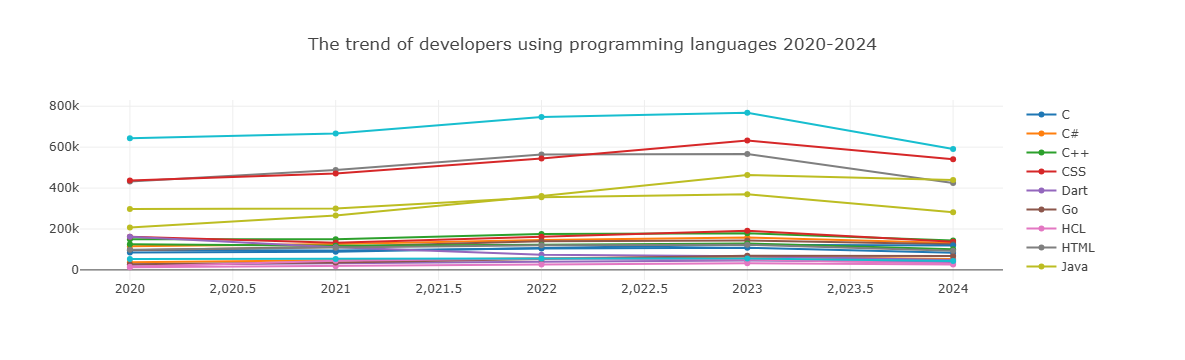

In [14]:
data = openDigger.driver.clickhouse.query(f"""
SELECT toYear(created_at) AS year, COUNT(DISTINCT actor_id) AS user_count, COUNT(DISTINCT repo_id) AS repo_count, repo_language
FROM events
WHERE toYear(created_at) IN ('{"', '".join(map(str, years))}') AND repo_language IN (
    SELECT repo_language FROM (
        SELECT COUNT(DISTINCT actor_id) AS user_count, COUNT(DISTINCT repo_id) AS repo_count, repo_language
        FROM events
        WHERE repo_language != '' AND toYear(created_at) = '{year}'
        GROUP BY repo_language
        ORDER BY user_count DESC
        LIMIT 20
    )
)
GROUP BY year, repo_language
ORDER BY year DESC, user_count DESC
""", {"format": "JSONEachRow"})
df_data = pd.DataFrame(data)
data_lang_dict_list = {k: v.to_dict("list") for k, v in df_data.groupby("repo_language")}
data_records = list(map(repo_language_usecount_postprocess, data_lang_dict_list.values()))
openDigger.render.plotly(
    data_records,
    {"title": f"The trend of developers using programming languages {startYear}-{year}", "xasix": {"type": "category"}},
    MultiMime()
)

## 5.技术领域项目分析

技术领域的发展在开源技术中起着风向标的作用，众多技术子领域展现出快速的进步和变革：操作系统领域不断适配新架构，在开源社区中持续演化；云原生技术推动企业实现数字化转型，其开源项目生态活跃且增长迅速；数据库作为数据创新的核心基础设施，开源技术的广泛应用促进了多样化场景的突破；大数据领域依托开源工具，正为智能决策提供强大支撑；人工智能借助开源框架加速各行业的自动化进程；前端技术则通过开源项目推动交互体验与视觉设计的不断提升。这些领域以其开放性和创新性吸引了众多开发者与投资者的关注，本节将基于影响力和活跃度两大指标对其进行数据洞察分析。

### 5.1 各子领域近5年变化趋势

In [15]:
def processTechSubfieldsRepoOpenrank(options, title_meta, use_simple_name=True):
    data = openDigger.index.openrank.getRepoOpenrank(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = data_df_formated.apply(row_openrank_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

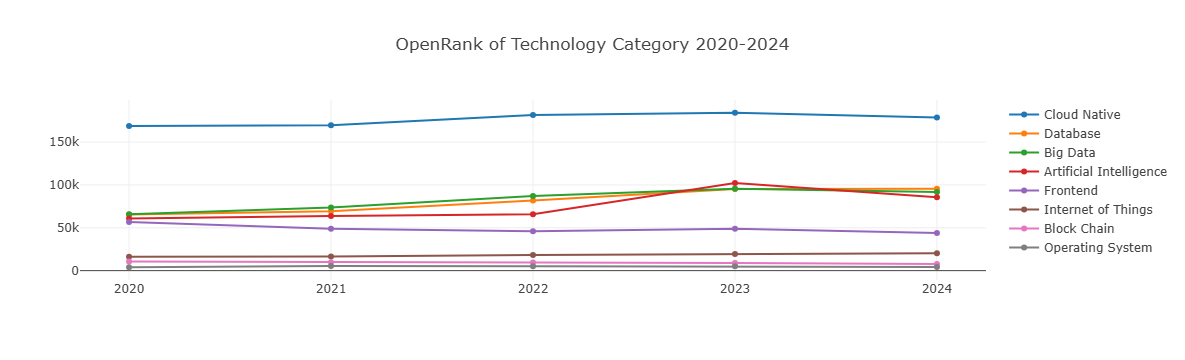

In [16]:
processTechSubfieldsRepoOpenrank({
    "labelUnion": ['Tech-0'],  # ':technology' is invalid because there is no such a top level label for the technology directory. 'Tech-0' can be used to represent the first level technical field label
    "startYear": startYear, "endYear": year, "endMonth": 12,
    "groupBy": 'Tech-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {"title": f"OpenRank of Technology Category {startYear}-{year}", "xaxis": { "type": 'category' }})

In [17]:
def processTechSubfieldsRepoActivity(options, title_meta, use_simple_name=True):
    data = openDigger.index.activity.getRepoActivity(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = data_df_formated.apply(row_activity_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

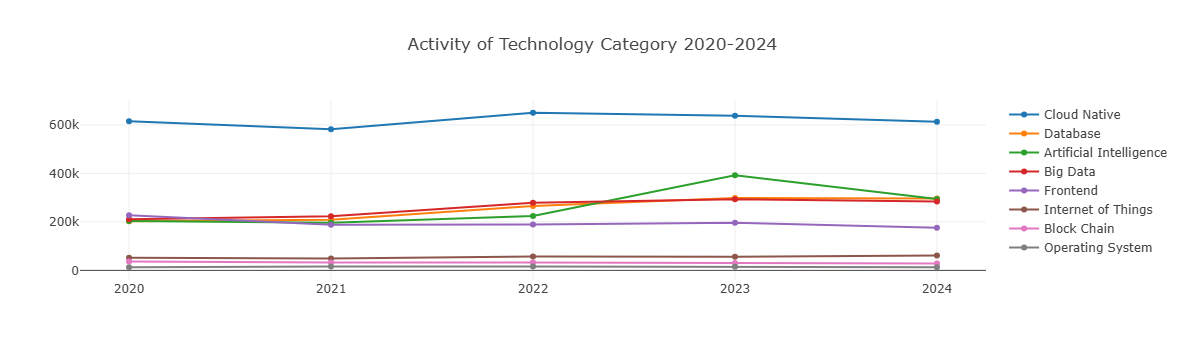

In [18]:
processTechSubfieldsRepoActivity({
    "labelUnion": ['Tech-0'],
    "startYear": startYear, "endYear": year, "endMonth": 12,
    "groupBy": 'Tech-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {"title": f"Activity of Technology Category {startYear}-{year}", "xaxis": { "type": 'category' }})

### 5.2 各领域 OpenRank Top 10项目近五年变化趋势

In [19]:
def processTechFieldRepoOpenrank(label, title):
    data = openDigger.index.openrank.getRepoOpenrank(
        dict(**baseOptions, 
             **{"labelIntersect": [label], "limit": 10}
            )
    )
    data_records = pd.DataFrame(data).apply(row_openrank_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records,
        {"title": f"Top 10 OpenRank repositories of {title} {startYear}-{year}"},
        MultiMime()
    )

In [20]:
def processTechFieldRepoActivity(label, title):
    data = openDigger.index.activity.getRepoActivity(
        dict(**baseOptions, 
             **{"labelIntersect": [label], "limit": 10}
            )
    )
    data_records = pd.DataFrame(data).apply(row_activity_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records, 
        {"title": f"Top 10 Activity repositories of {title} {startYear}-{year}"},
        MultiMime()
    )

### 大数据

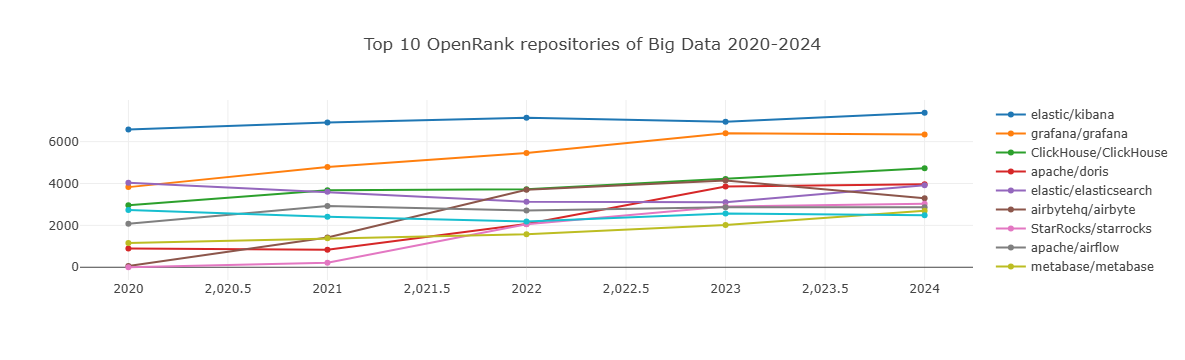

In [21]:
processTechFieldRepoOpenrank(':technology/big_data', 'Big Data');

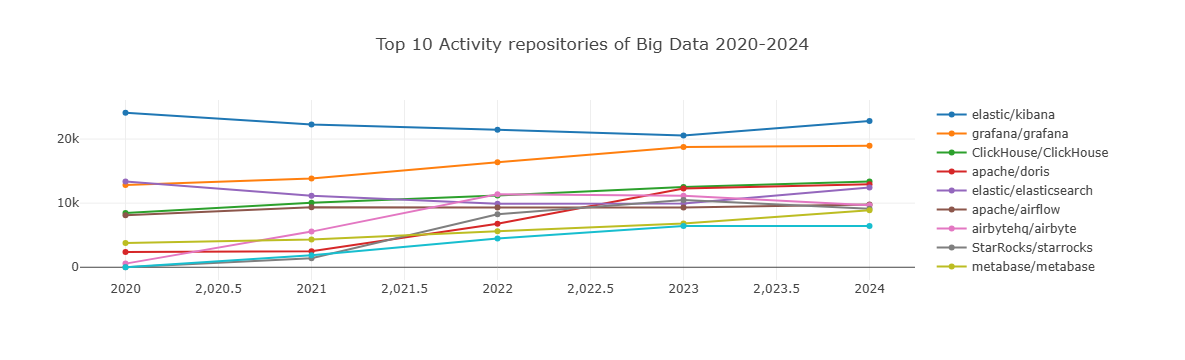

In [22]:
processTechFieldRepoActivity(':technology/big_data', 'Big Data')

### 数据库

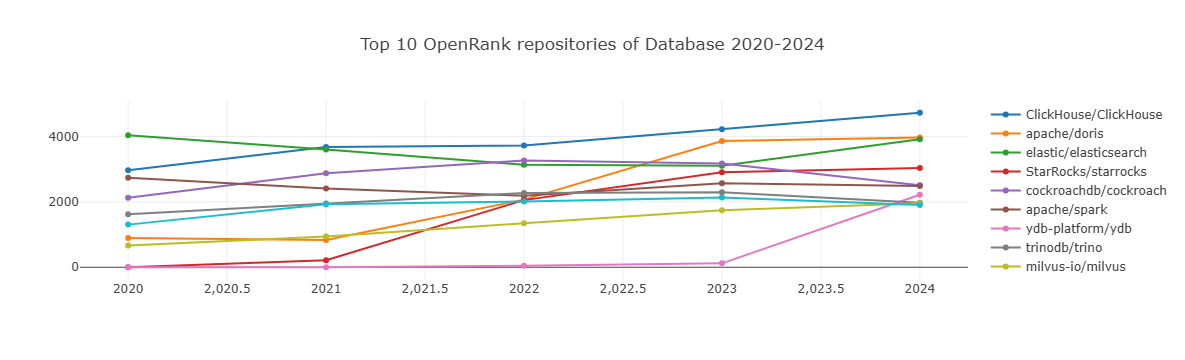

In [23]:
processTechFieldRepoOpenrank(':technology/database', 'Database');

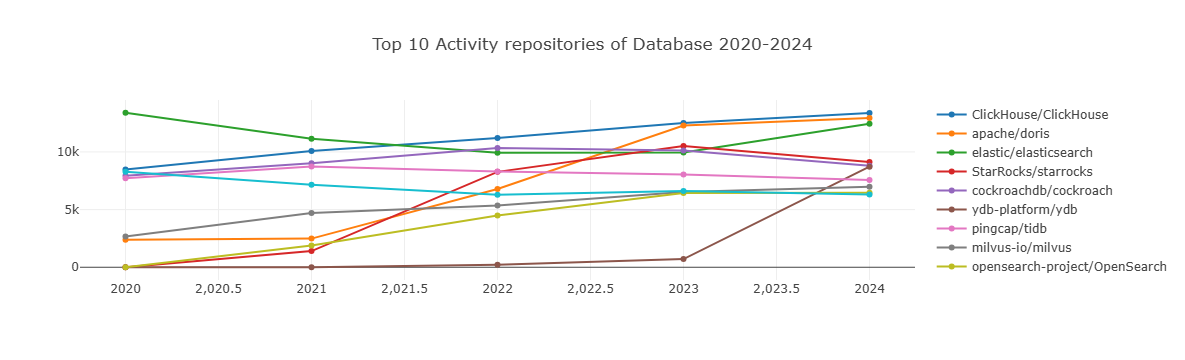

In [24]:
processTechFieldRepoActivity(':technology/database', 'Database');

### 操作系统

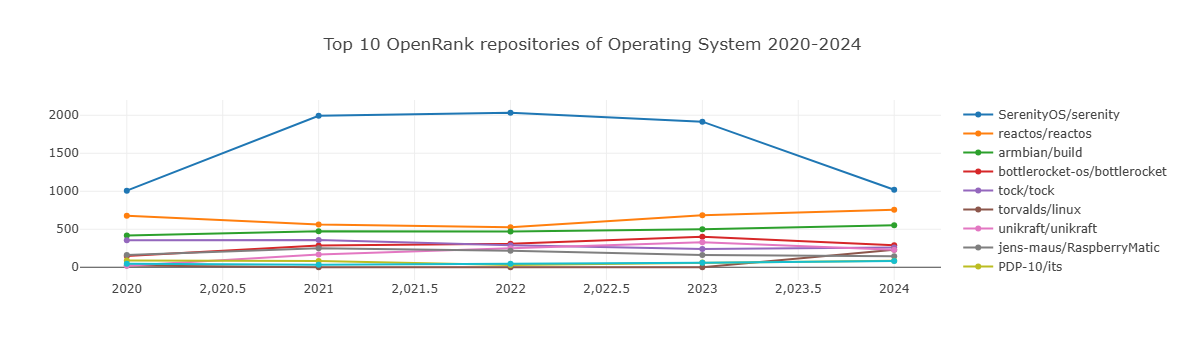

In [25]:
processTechFieldRepoOpenrank(':technology/operating_system', 'Operating System');

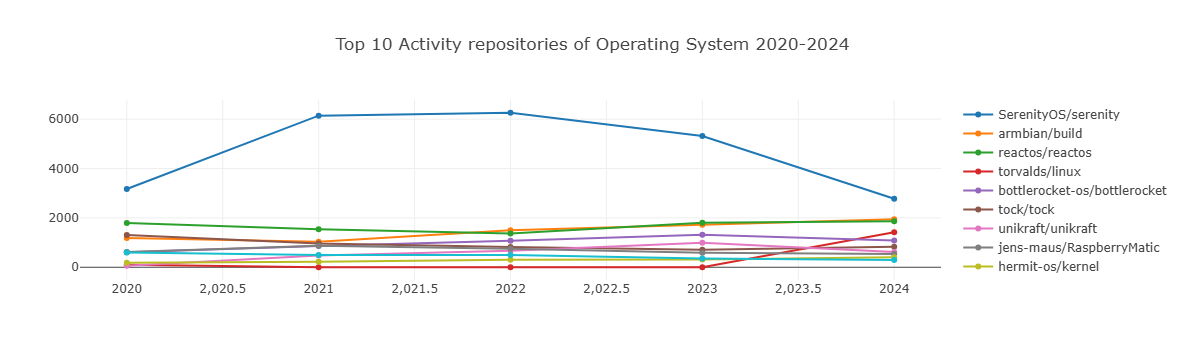

In [26]:
processTechFieldRepoActivity(':technology/operating_system', 'Operating System');

### 云原生

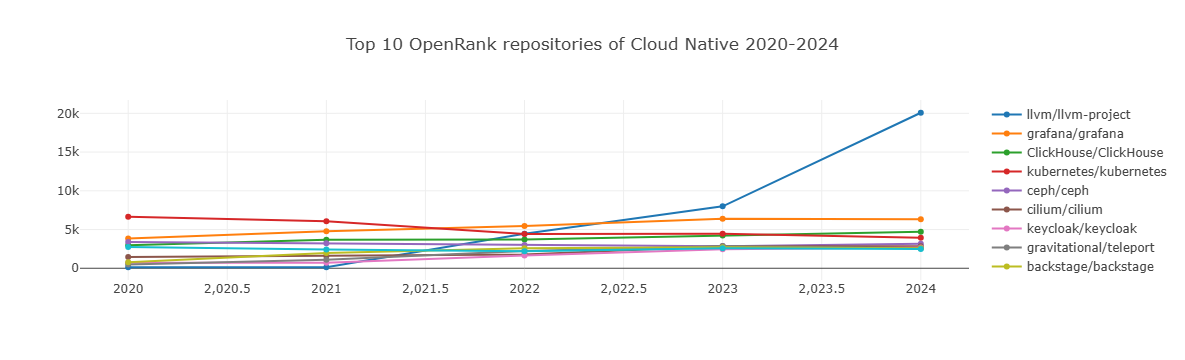

In [27]:
processTechFieldRepoOpenrank(':technology/cloud_native', 'Cloud Native');

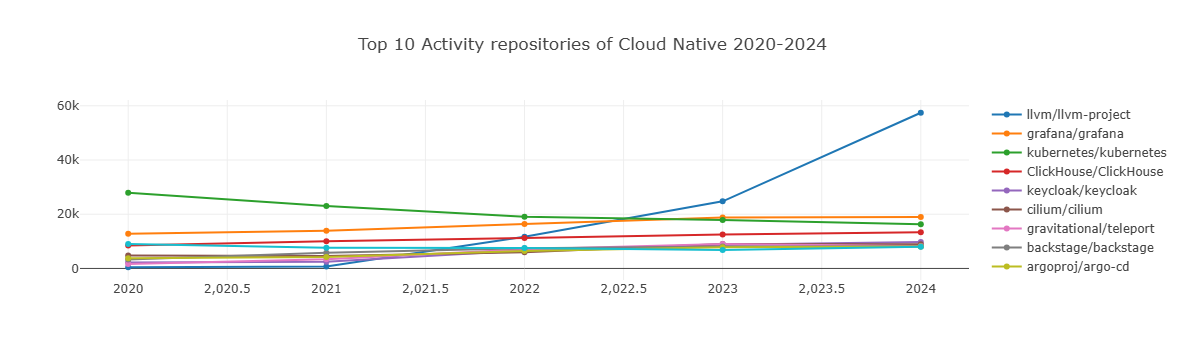

In [28]:
processTechFieldRepoActivity(':technology/cloud_native', 'Cloud Native');

### 前端

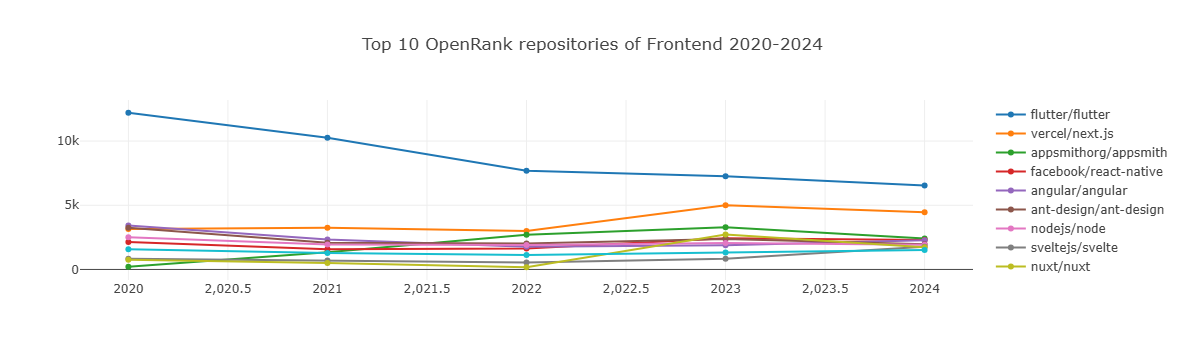

In [29]:
processTechFieldRepoOpenrank(':technology/frontend', 'Frontend');

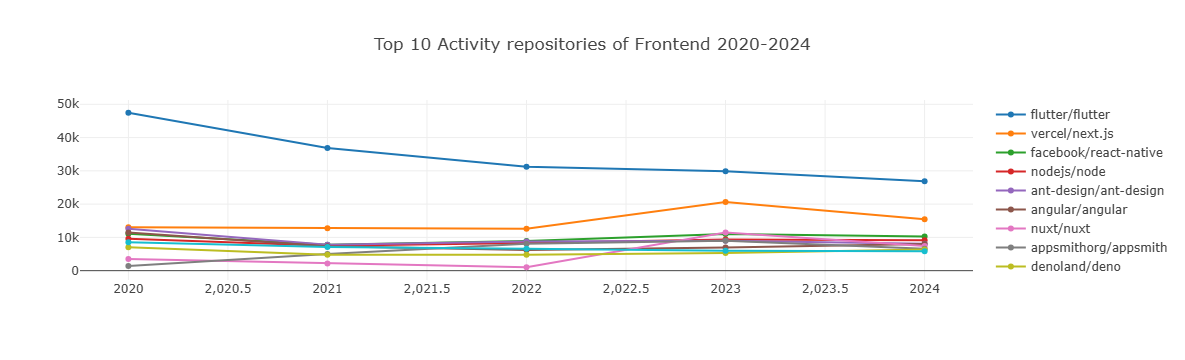

In [30]:
processTechFieldRepoActivity(':technology/frontend', 'Frontend');

### 人工智能

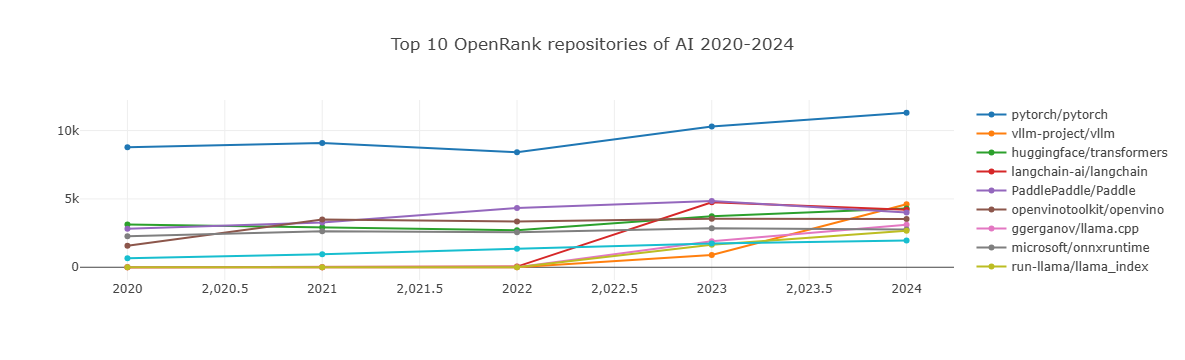

In [31]:
processTechFieldRepoOpenrank(':technology/ai', 'AI');

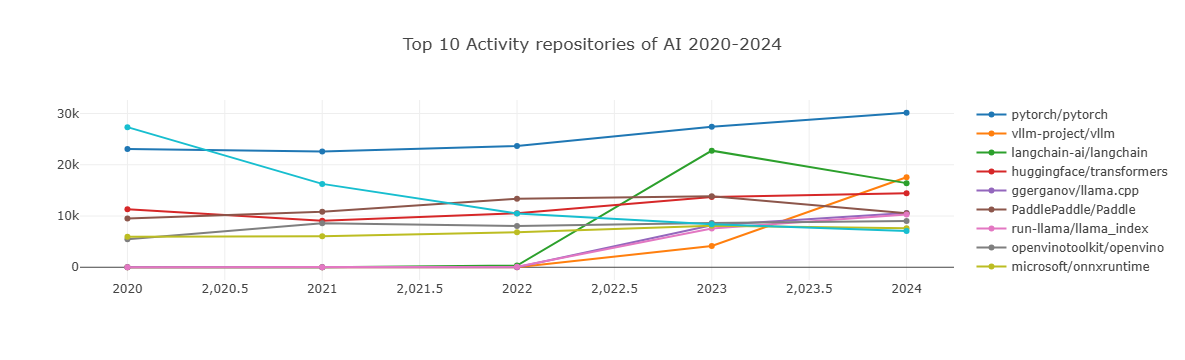

In [32]:
processTechFieldRepoActivity(':technology/ai', 'AI');

### 5.3 各领域OpenRank Top 10 榜单

### 大数据

In [33]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/big_data'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
data = simplify_rank_df(data, 'openrank')
displaymime(data)

|    |        id | platform   | name                  |   openrank |
|---:|----------:|:-----------|:----------------------|-----------:|
|  0 |   7833168 | GitHub     | elastic/kibana        |    7380.26 |
|  1 |  15111821 | GitHub     | grafana/grafana       |    6335.71 |
|  2 |  60246359 | GitHub     | ClickHouse/ClickHouse |    4726.33 |
|  3 |  99919302 | GitHub     | apache/doris          |    3965.48 |
|  4 |    507775 | GitHub     | elastic/elasticsearch |    3912.42 |
|  5 | 283046497 | GitHub     | airbytehq/airbyte     |    3299.4  |
|  6 | 402945349 | GitHub     | StarRocks/starrocks   |    3034.08 |
|  7 |  33884891 | GitHub     | apache/airflow        |    2867.69 |
|  8 |  30203935 | GitHub     | metabase/metabase     |    2699.49 |
|  9 |  17165658 | GitHub     | apache/spark          |    2485.28 |

### 数据库

In [34]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/database'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
data = simplify_rank_df(data, 'openrank')
displaymime(data)

|    |        id | platform   | name                  |   openrank |
|---:|----------:|:-----------|:----------------------|-----------:|
|  0 |  60246359 | GitHub     | ClickHouse/ClickHouse |    4726.33 |
|  1 |  99919302 | GitHub     | apache/doris          |    3965.48 |
|  2 |    507775 | GitHub     | elastic/elasticsearch |    3912.42 |
|  3 | 402945349 | GitHub     | StarRocks/starrocks   |    3034.08 |
|  4 |  16563587 | GitHub     | cockroachdb/cockroach |    2506.6  |
|  5 |  17165658 | GitHub     | apache/spark          |    2485.28 |
|  6 | 456549280 | GitHub     | ydb-platform/ydb      |    2216.9  |
|  7 | 166515022 | GitHub     | trinodb/trino         |    1969.74 |
|  8 | 208728772 | GitHub     | milvus-io/milvus      |    1955.52 |
|  9 | 105944401 | GitHub     | yugabyte/yugabyte-db  |    1904.26 |

### 操作系统

In [35]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/operating_system'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
data = simplify_rank_df(data, 'openrank')
displaymime(data)

|    |        id | platform   | name                         |   openrank |
|---:|----------:|:-----------|:-----------------------------|-----------:|
|  0 | 160083795 | GitHub     | SerenityOS/serenity          |    1020.8  |
|  1 | 105627846 | GitHub     | reactos/reactos              |     757.97 |
|  2 |  24905898 | GitHub     | armbian/build                |     551.48 |
|  3 | 179385712 | GitHub     | bottlerocket-os/bottlerocket |     290.52 |
|  4 |  36428094 | GitHub     | tock/tock                    |     259.8  |
|  5 |   2325298 | GitHub     | torvalds/linux               |     230.9  |
|  6 | 181022316 | GitHub     | unikraft/unikraft            |     229.1  |
|  7 |  61721573 | GitHub     | jens-maus/RaspberryMatic     |     143.33 |
|  8 |  71775220 | GitHub     | PDP-10/its                   |      85.37 |
|  9 | 135060910 | GitHub     | hermit-os/kernel             |      83.2  |

### 云原生

In [36]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/cloud_native'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
data = simplify_rank_df(data, 'openrank')
displaymime(data)

|    |        id | platform   | name                   |   openrank |
|---:|----------:|:-----------|:-----------------------|-----------:|
|  0 |  75821432 | GitHub     | llvm/llvm-project      |   20074.7  |
|  1 |  15111821 | GitHub     | grafana/grafana        |    6335.71 |
|  2 |  60246359 | GitHub     | ClickHouse/ClickHouse  |    4726.33 |
|  3 |  20580498 | GitHub     | kubernetes/kubernetes  |    3924.93 |
|  4 |   2310495 | GitHub     | ceph/ceph              |    3173.94 |
|  5 |  48109239 | GitHub     | cilium/cilium          |    2842.98 |
|  6 |  11125589 | GitHub     | keycloak/keycloak      |    2687.79 |
|  7 |  31558937 | GitHub     | gravitational/teleport |    2584.11 |
|  8 | 236095576 | GitHub     | backstage/backstage    |    2573.87 |
|  9 |  17165658 | GitHub     | apache/spark           |    2485.28 |

### 前端

In [37]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/frontend'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
data = simplify_rank_df(data, 'openrank')
displaymime(data)

|    |        id | platform   | name                  |   openrank |
|---:|----------:|:-----------|:----------------------|-----------:|
|  0 |  31792824 | GitHub     | flutter/flutter       |    6531.03 |
|  1 |  70107786 | GitHub     | vercel/next.js        |    4450.37 |
|  2 | 275993885 | GitHub     | appsmithorg/appsmith  |    2402.2  |
|  3 |  29028775 | GitHub     | facebook/react-native |    2302.11 |
|  4 |  24195339 | GitHub     | angular/angular       |    2269.04 |
|  5 |  34526884 | GitHub     | ant-design/ant-design |    1962.73 |
|  6 |  27193779 | GitHub     | nodejs/node           |    1925.41 |
|  7 |  74293321 | GitHub     | sveltejs/svelte       |    1760.16 |
|  8 |  71995937 | GitHub     | nuxt/nuxt             |    1734.85 |
|  9 | 133442384 | GitHub     | denoland/deno         |    1520.36 |

### 人工智能

In [38]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/ai'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
data = simplify_rank_df(data, 'openrank')
displaymime(data)

|    |        id | platform   | name                     |   openrank |
|---:|----------:|:-----------|:-------------------------|-----------:|
|  0 |  65600975 | GitHub     | pytorch/pytorch          |   11303    |
|  1 | 599547518 | GitHub     | vllm-project/vllm        |    4611    |
|  2 | 155220641 | GitHub     | huggingface/transformers |    4292.13 |
|  3 | 552661142 | GitHub     | langchain-ai/langchain   |    4212.26 |
|  4 |  65711522 | GitHub     | PaddlePaddle/Paddle      |    4001.71 |
|  5 | 153097643 | GitHub     | openvinotoolkit/openvino |    3538.16 |
|  6 | 612354784 | GitHub     | ggerganov/llama.cpp      |    3110.07 |
|  7 | 156939672 | GitHub     | microsoft/onnxruntime    |    2758.39 |
|  8 | 560704231 | GitHub     | run-llama/llama_index    |    2665.89 |
|  9 | 208728772 | GitHub     | milvus-io/milvus         |    1955.52 |

## 6.开源项目洞察

### 6.1 项目类型

#### 6.1.1 不同项目类型数量比例

In [39]:
def df_count_postprocess(df):
    return [{
        "labels": df["name"].values.tolist(),
        "values": df["repos"].apply(lambda x: float(x[0])).values.tolist(),
        "type": 'pie',
        "name": 'times',
        "textinfo": "label+percent"
    }]

def processAppDomainRatioRepoCount(options, title_meta):
    data = openDigger.index.openrank.getRepoOpenrank(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':application_domain'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    # data_df_formated.to_csv('./data_df_formated.csv')
    data_records = df_count_postprocess(data_df_formated)
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

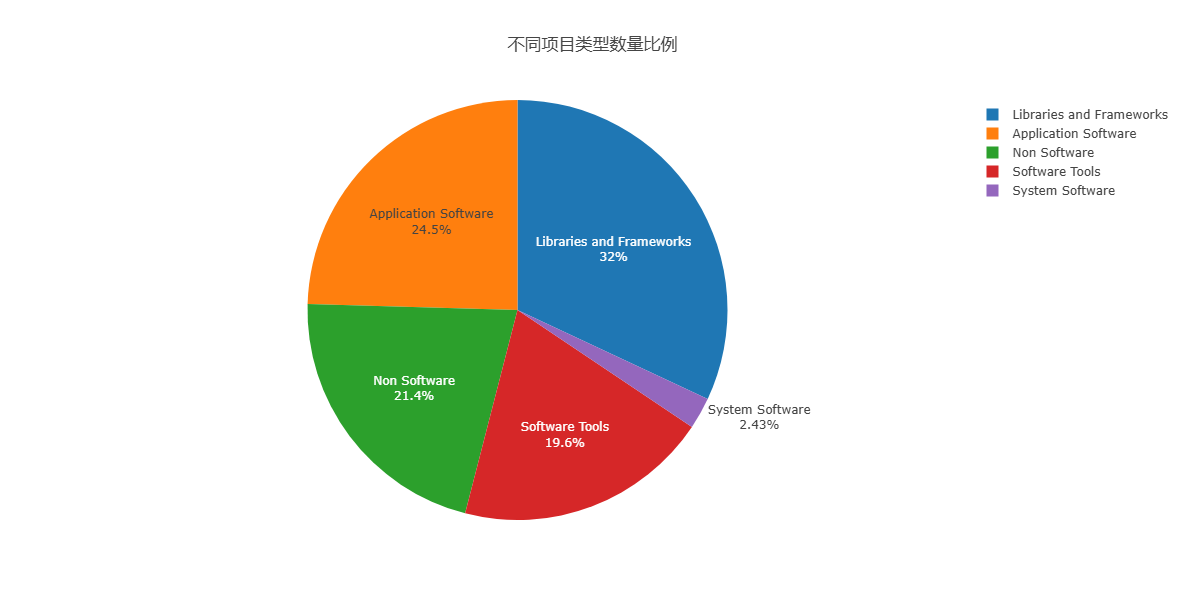

In [40]:
processAppDomainRatioRepoCount({
    "labelUnion": [':application_domain'],
    "startYear": year, "endYear": year, "endMonth": 12,
    "groupBy": 'Domain-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {
    "title": '不同项目类型数量比例',
    "xaxis": {"type": 'category'},
    "height": 600,
    # "width":1050,
})

#### 6.1.2 不同项目类型 OpenRank 加总比例

In [41]:
def df_openrank_postprocess(df):
    return [{
        "labels": df["name"].values.tolist(),
        "values": df["openrank"].apply(lambda x: x[0]).values.tolist(),
        "type": 'pie',
        "name": 'times',
        "textinfo": "label+percent"
    }]

def processAppDomainRatioRepoOpenrank(options, title_meta):
    data = openDigger.index.openrank.getRepoOpenrank(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':application_domain'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = df_openrank_postprocess(data_df_formated)
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

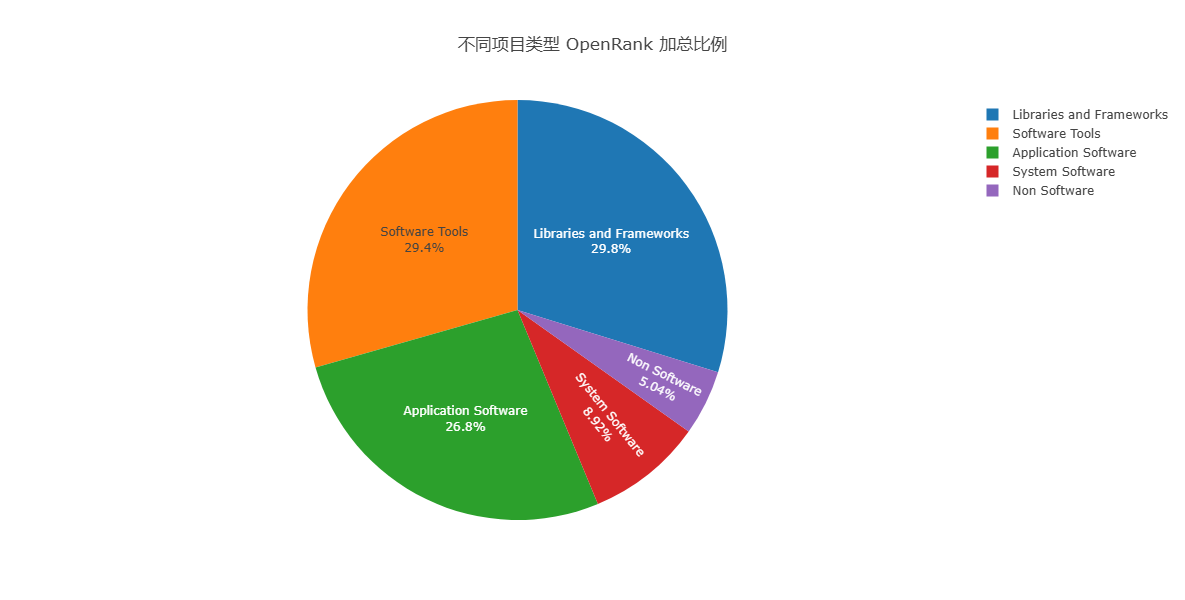

In [42]:
processAppDomainRatioRepoOpenrank({
    "labelUnion": [':application_domain'],
    "startYear": year, "endYear": year, "endMonth": 12,
    "groupBy": 'Domain-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {
    "title": '不同项目类型 OpenRank 加总比例',
    "xaxis": {"type": 'category'},
    "height": 600,
    # "width":1050,
})

#### 6.1.3 不同项目类型 近5年 OpenRank 变化趋势

In [43]:
def processApplySubfieldsRepoOpenrank(options, title_meta, use_simple_name=True):
    data = openDigger.index.openrank.getRepoOpenrank(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':application_domain'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = data_df_formated.apply(row_openrank_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

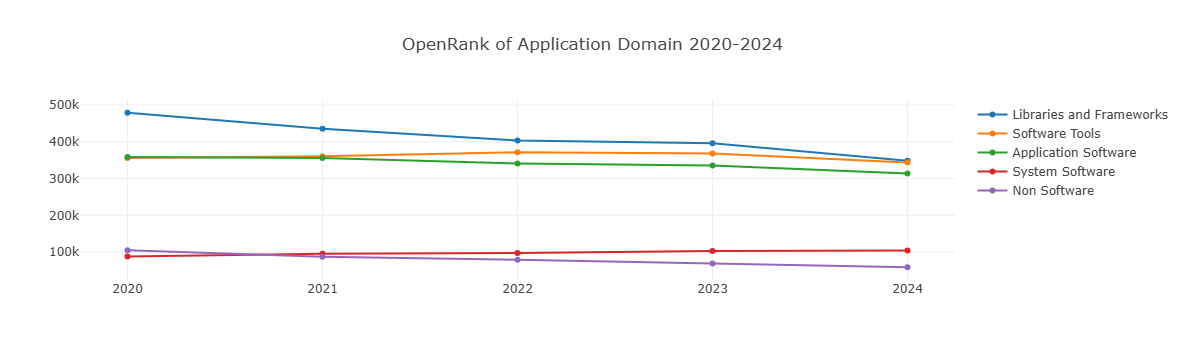

In [44]:
processApplySubfieldsRepoOpenrank({
    "labelUnion": [':application_domain'],
    "startYear": startYear, "endYear": year, "endMonth": 12,
    "groupBy": 'Domain-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {"title": f"OpenRank of Application Domain {startYear}-{year}", "xaxis": { "type": 'category' }})

### 6.2 项目 Topic 分析

### 6.3 数据库领域项目分析

本小节依据 [Database of Databases](https://dbdb.io/) 及 [DB-Engines Ranking](https://db-engines.com/en/ranking) 中公开的开源数据库信息，将该领域按数据库的存储结构及用途划分为 Relational、Key-value、Document、Search Engine、Wide Column、Time Series、Graph、Vector、Object Oriented、Hierarchical、RDF、Array、Event、Spatial、Native XML、Multivalue、Content、 Network 18 个子类，收集并分析其在 GitHub 上的相应数据库开源项目的协作日志数据。

In [12]:
def df_repos_count_each_year_postprocess(row):
    return {
        "x": years,
        "y": [float(e) for e in row["repos"]],
        "name": row["name"],
    }

def processDataBaseRatioRepoCount(options, title_meta):
    data = openDigger.index.openrank.getRepoOpenrank(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    # data_df_formated.to_csv('./data_df_formated.csv')
    data_records = data_df_formated.apply(df_repos_count_each_year_postprocess, axis=1).values
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

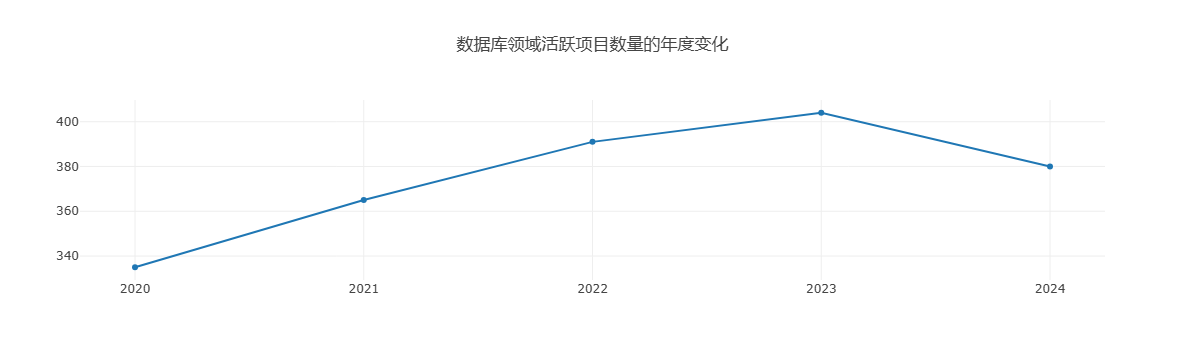

In [13]:
options = dict(
    baseOptions, 
    **{"labelUnion": ['Tech-0'],
    "groupBy": 'Tech-0',
    "limit": -1
    }
)
data_df_formated = processDataBaseRatioRepoCount(options, title_meta={
    "title": '数据库领域活跃项目数量的年度变化',
    "xaxis": {"type": 'category'},
})

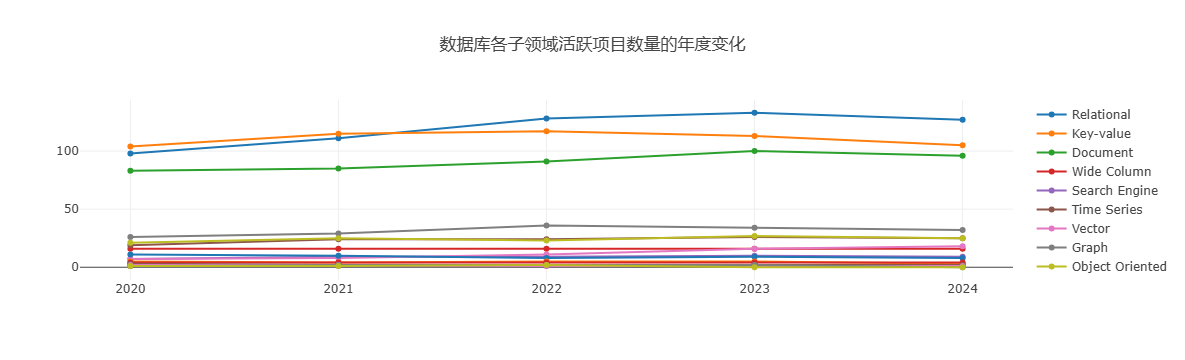

In [14]:
options = dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1
    }
)
data_df_formated = processDataBaseRatioRepoCount(options, title_meta={
    "title": '数据库各子领域活跃项目数量的年度变化',
    "xaxis": {"type": 'category'},
})

### 数据库领域 近5年 OpenRank和Activity 变化趋势

领域竞争格局：领域内头部项目的集中度与领域指标变化趋势对比

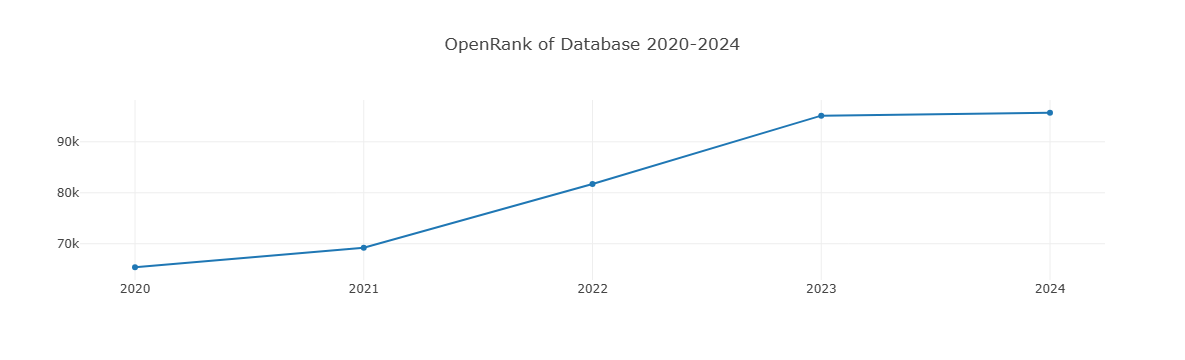

In [15]:
data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": ['Tech-0'],
    "groupBy": 'Tech-0',
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_records = data_df_filtered.apply(row_openrank_postprocess, axis=1).values.tolist()
title_meta = {"title": f"OpenRank of Database {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

In [16]:
def get_columns_topN_ratio(df, topN=10, filtered_by='nlargest', percentage=True):
    column_sums = df.sum()
    if filtered_by == 'nlargest':
        topn_values = df.apply(lambda col: col.nlargest(topN).sum(), axis=0)
    elif filtered_by == 'header':
        topn_values = df.apply(lambda col: col.header(topN).sum(), axis=0)
    else:
        raise ValueError("filtered_by must be in ['nlargest', 'header'].")
    ratio = topn_values / column_sums
    if percentage:
        ratio = 100 * ratio
    return ratio

def topN_ratio_postprocess(df, metric='openrank', topN=10, percentage=True):
    df_metric_repos_years = df[metric].apply(pd.Series)
    ratio_col_name = f"{metric}_top{str(topN)}_ratio"
    ser_topN_ratio = get_columns_topN_ratio(df_metric_repos_years, topN=topN, percentage=percentage)
    
    return {
        "x": years,
        "y": list(ser_topN_ratio.values),
        "name": ratio_col_name
    }

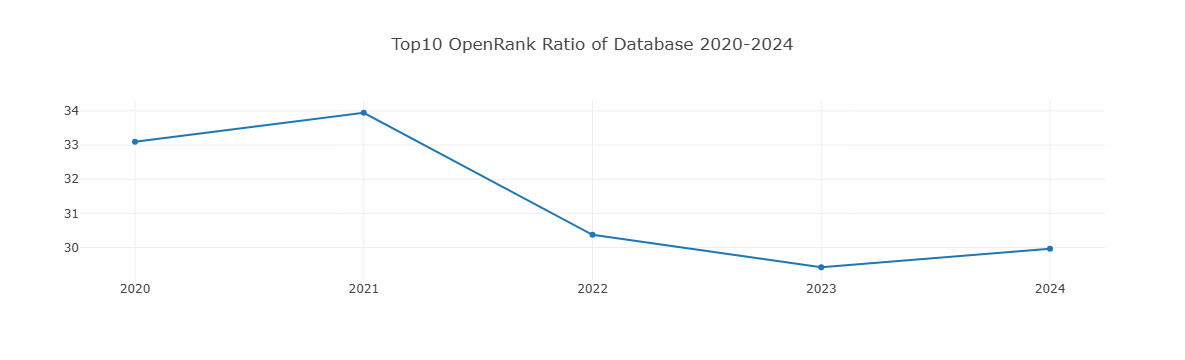

In [17]:
data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'],
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_records = [topN_ratio_postprocess(data_df, metric='openrank', percentage=True)]
title_meta = {"title": f"Top{topN} OpenRank Ratio of Database {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

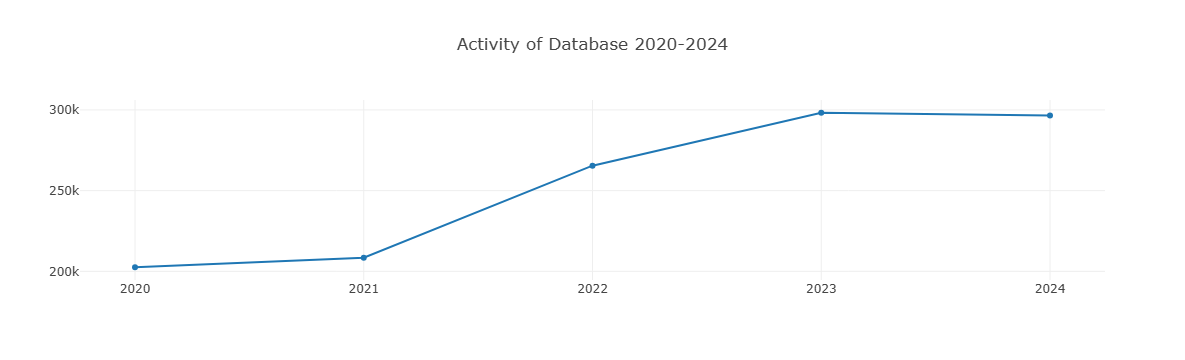

In [18]:
data = openDigger.index.activity.getRepoActivity(dict(
    baseOptions, 
    **{"labelUnion": ['Tech-0'],
    "groupBy": 'Tech-0',
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_records = data_df_filtered.apply(row_activity_postprocess, axis=1).values.tolist()
title_meta = {"title": f"Activity of Database {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

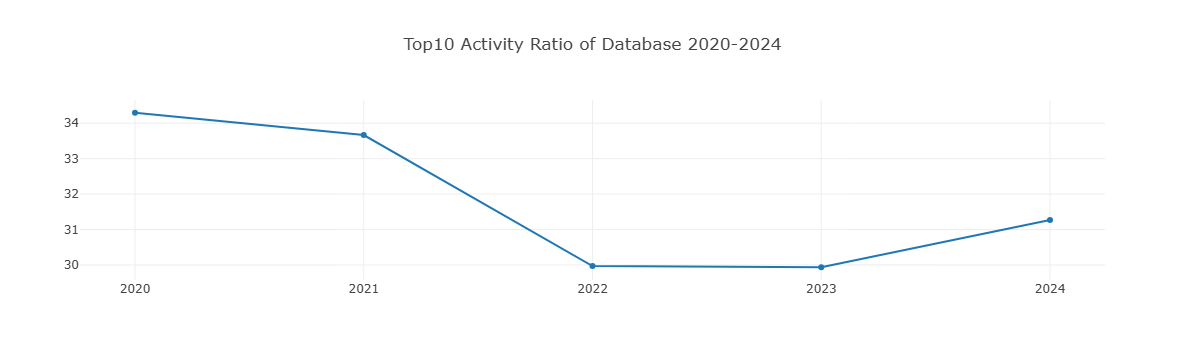

In [19]:
data = openDigger.index.activity.getRepoActivity(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'],
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_records = [topN_ratio_postprocess(data_df, metric='activity', percentage=True)]
title_meta = {"title": f"Top{topN} Activity Ratio of Database {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

#### 6.3.1 数据库各子领域近五年增长趋势

### 数据库领域各子领域 近5年 OpenRank 变化趋势

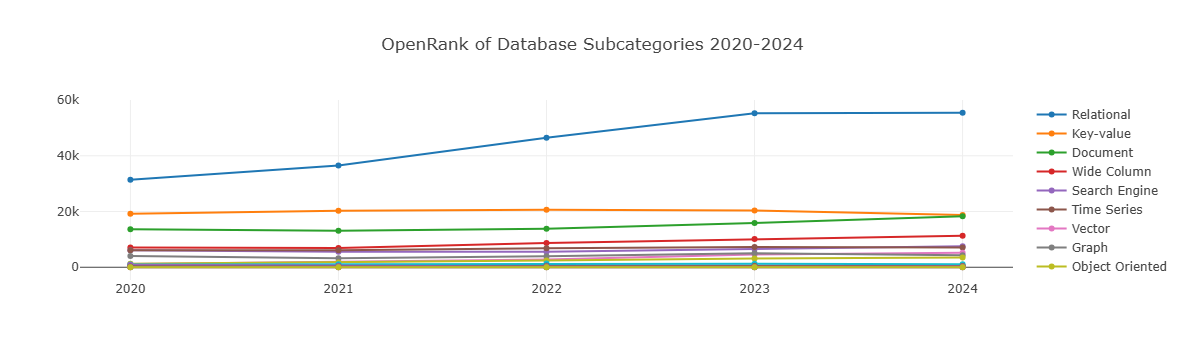

In [20]:
data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_records = data_df_formated.apply(row_openrank_postprocess, axis=1).values.tolist()
title_meta = {"title": f"OpenRank of Database Subcategories {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

In [21]:
def openrank_rank_postporcess(row):
    return {
        "x": years,
        "y": row["values"],
        "name": row["name"],
        "type": 'scatter'
    }
def processSubfieldRankRepoOpenrank(options, title):
    data = openDigger.index.openrank.getRepoOpenrank(dict(
        baseOptions, 
        **options
    ))
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["name"].startswith('Database - '), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = pd.DataFrame(data_df_formated).to_dict('records')
    data_periodranks = openDigger.getRank(data_records, lambda x: x["name"], lambda x: x["openrank"])
    data_periodranks_records = pd.DataFrame(data_periodranks).apply(openrank_rank_postporcess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_periodranks_records, 
        {
            "title": f"OpenRank of {title} Subcategories Ranking {startYear}-{year}", 
            "xaxis": { "type": 'category' }, 
            "yaxis": { "autorange": 'reversed', "dtick": 1 } 
        }, 
        MultiMime()
    )

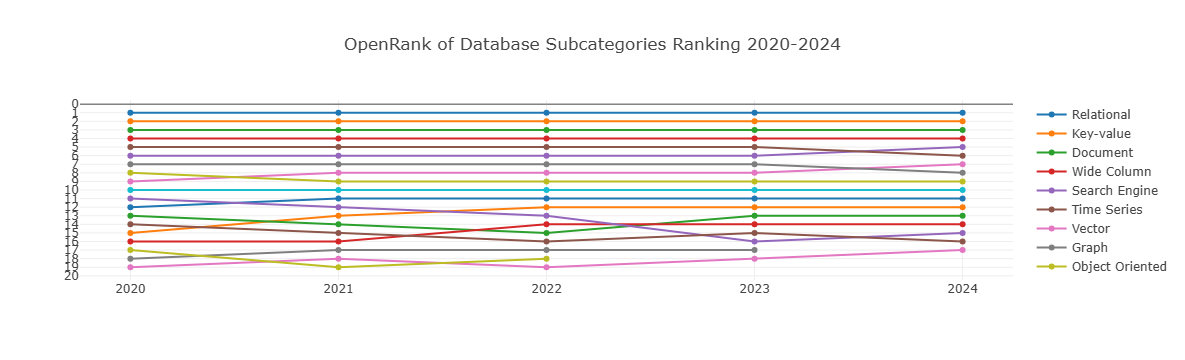

In [22]:
processSubfieldRankRepoOpenrank({
    "labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1}, "Database")

### 数据库领域各子领域 近5年 Activity 变化趋势

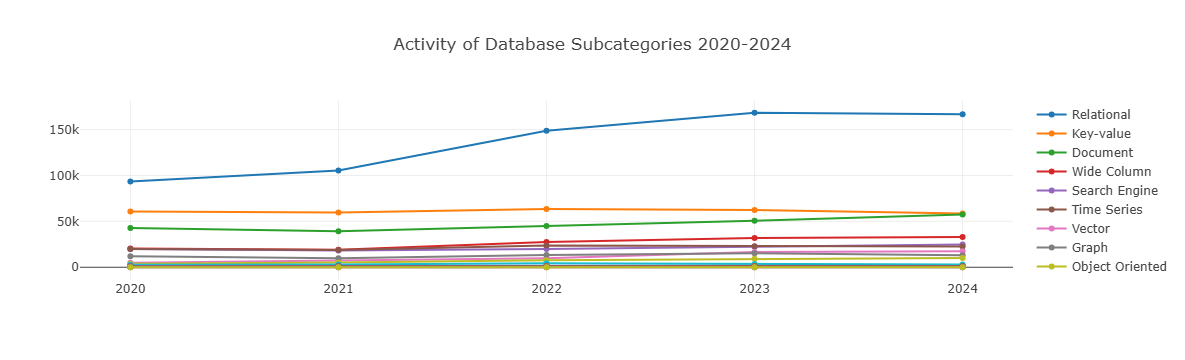

In [24]:
data = openDigger.index.activity.getRepoActivity(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_records = data_df_formated.apply(row_activity_postprocess, axis=1).values.tolist()
title_meta = {"title": f"Activity of Database Subcategories {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

In [25]:
def activity_rank_postporcess(row):
    return {
        "x": years,
        "y": row["values"],
        "name": row["name"],
        "type": 'scatter'
    }
def processSubfieldRankRepoActivity(options, title):
    data = openDigger.index.activity.getRepoActivity(dict(
        baseOptions, 
        **options
    ))
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["name"].startswith('Database - '), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = pd.DataFrame(data_df_formated).to_dict('records')
    data_periodranks = openDigger.getRank(data_records, lambda x: x["name"], lambda x: x["activity"])
    data_periodranks_records = pd.DataFrame(data_periodranks).apply(activity_rank_postporcess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_periodranks_records, 
        {
            "title": f"Activity of {title} Subcategories Ranking {startYear}-{year}", 
            "xaxis": { "type": 'category' }, 
            "yaxis": { "autorange": 'reversed', "dtick": 1 } 
        }, 
        MultiMime()
    )

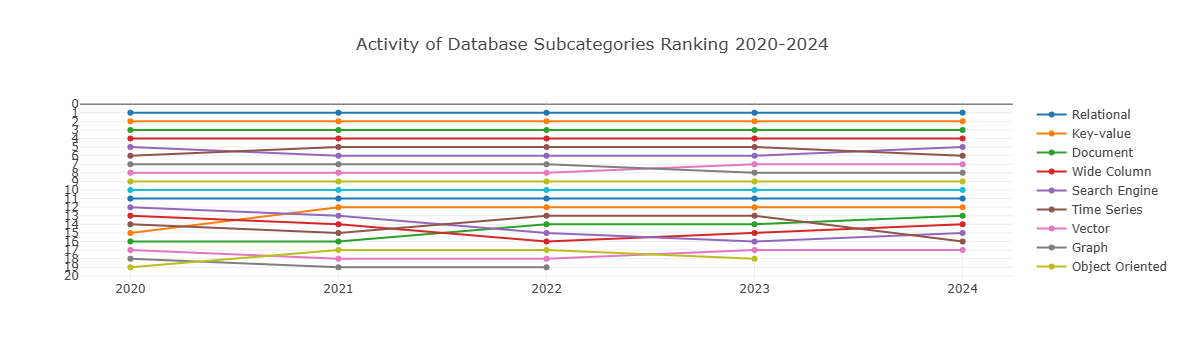

In [26]:
processSubfieldRankRepoActivity({
    "labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1}, "Database")

#### 6.3.2 数据库子领域 OpenRank 榜单和活跃度榜单

### 数据库领域各子领域 2024年 OpenRank 榜单

In [13]:
use_simple_name = True

In [28]:
data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], 
    "startYear": year, "endYear": year, 
    "groupBy": 'Tech-1', 
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_df_formated.reset_index(inplace=True)
data = simplify_rank_df(data_df_formated, 'openrank')
data['openrank_ratio'] = data['openrank'].apply(lambda x: 100*x/sum(data['openrank']))
displaymime(data)

|    | id                                   | platform   | name            |   openrank |   openrank_ratio |
|---:|:-------------------------------------|:-----------|:----------------|-----------:|-----------------:|
|  0 | :technology/database/relational      | All        | Relational      |   55440.5  |       41.334     |
|  1 | :technology/database/key_value       | All        | Key-value       |   18780.1  |       14.0016    |
|  2 | :technology/database/document        | All        | Document        |   18262    |       13.6154    |
|  3 | :technology/database/wide_column     | All        | Wide Column     |   11285.4  |        8.41389   |
|  4 | :technology/database/search_engine   | All        | Search Engine   |    7575.18 |        5.64772   |
|  5 | :technology/database/time_series     | All        | Time Series     |    7111.37 |        5.30192   |
|  6 | :technology/database/vector          | All        | Vector          |    5187.47 |        3.86755   |
|  7 | :technology/

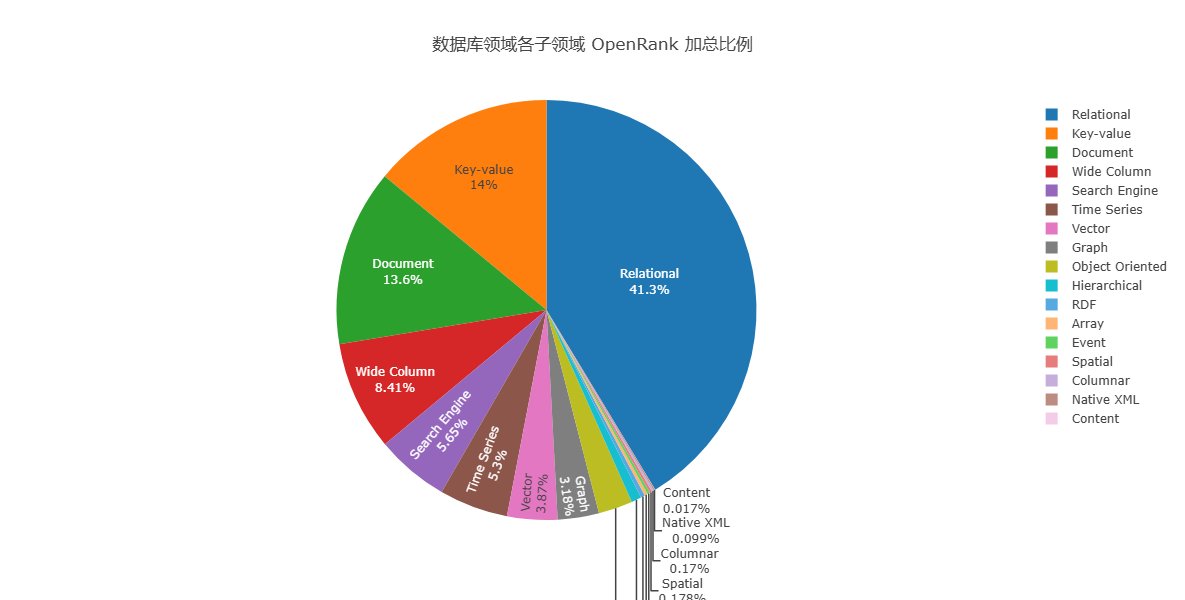

In [29]:
def drawDatabaseRatioRepoOpenrank(data_df, title_meta):
    data_records = [{
        "labels": data_df["name"].values.tolist(),
        "values": data_df["openrank"].values.tolist(),
        "type": 'pie',
        "name": 'times',
        "textinfo": "label+percent"
    }]
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

drawDatabaseRatioRepoOpenrank(data, {
    "title": '数据库领域各子领域 OpenRank 加总比例',
    "xaxis": {"type": 'category'},
    "height": 600,
    # "width":1050,
})

### 数据库领域各子领域 2024年 Activity 榜单

In [12]:
data = openDigger.index.activity.getRepoActivity(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], 
    "startYear": year, "endYear": year, 
    "groupBy": 'Tech-1', 
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_df_formated.reset_index(inplace=True)
data = simplify_rank_df(data_df_formated, 'activity')
data['activity_ratio'] = data['activity'].apply(lambda x: 100*x/sum(data['activity']))
displaymime(data)

|    | id                                   | platform   | name            |   activity |   activity_ratio |
|---:|:-------------------------------------|:-----------|:----------------|-----------:|-----------------:|
|  0 | :technology/database/relational      | All        | Relational      |  166707    |       40.4575    |
|  1 | :technology/database/key_value       | All        | Key-value       |   58567.1  |       14.2134    |
|  2 | :technology/database/document        | All        | Document        |   57491.4  |       13.9524    |
|  3 | :technology/database/wide_column     | All        | Wide Column     |   32835.4  |        7.96871   |
|  4 | :technology/database/search_engine   | All        | Search Engine   |   24881.8  |        6.03848   |
|  5 | :technology/database/time_series     | All        | Time Series     |   22610.5  |        5.48727   |
|  6 | :technology/database/vector          | All        | Vector          |   17463.4  |        4.23814   |
|  7 | :technology/

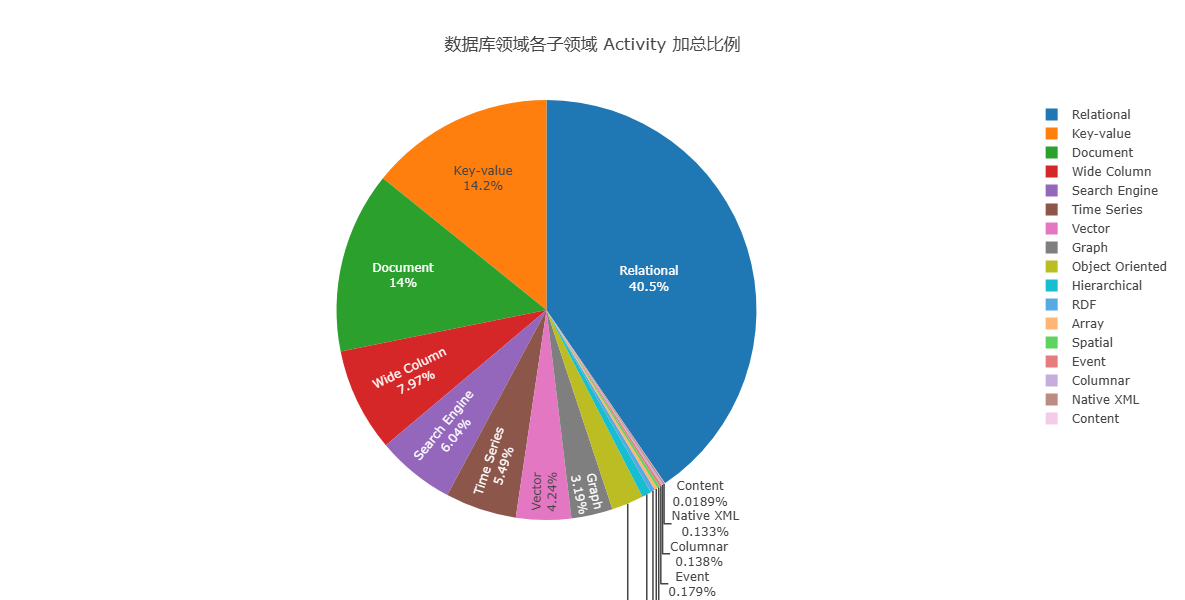

In [14]:
def drawDatabaseRatioRepoActivity(data_df, title_meta):
    data_records = [{
        "labels": data_df["name"].values.tolist(),
        "values": data_df["activity"].values.tolist(),
        "type": 'pie',
        "name": 'times',
        "textinfo": "label+percent"
    }]
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

drawDatabaseRatioRepoActivity(data, {
    "title": '数据库领域各子领域 Activity 加总比例',
    "xaxis": {"type": 'category'},
    "height": 600,
    # "width":1050,
})

从数据库领域各子领域 2024 年的 OpenRank 和活跃度排行可以看出：

- Relational、Key-value、Document 在以上两项指标中都稳据前三，前三名的数据库子领域的两项指标累计均占数据库领域两项指标的 70% 以上；
- Relational 的各项指标超过了第二至第五名的总和，其两项指标均占数据库领域两项指标的 40% 以上，是一个超大子类。
- Columnar作为新加入榜单的数据库项目发展势头迅猛
- 向量数据库在2024年也有了显著的提升。

#### 6.3.3 数据库领域各子领域下项目的开源象限图

开源象限图共涉及三个度量指标：Activity、Openrank、CommunityVolume。 其中 CommunityVolume 与 open-digger 中的 Attention 指标计算公式相同，即对一定时间内目标项目的 star 数和 fork 数的加权求和：`sum(1*star+2*fork)`。

象限图绘制方法：

1. 把每个数据库子类按 activity 选取 Top 10 的项目；
2. 做出 `log(openrank)-log(communityvolume)` 的 `log(x)-log(y)` 散点图, log 的底数均为 2，分别表示空间影响力 openrank 与时间影响力 communityvolume 衰减到 1 所需的半衰次数；
3. 以图上所有点的横坐标均值所对应的纵向线作为纵轴，以图上所有点的纵坐标均值所对应的横向线作为横轴划分为四个象限。

数据库领域子类标签共计18个，选取2023年活跃度占比超过1%的前9个类别统计分析，绘制开源象限图如下：

In [31]:
year_str = str(year)
func_opendigger_metric_dict = {
    "activity": openDigger.index.activity.getRepoActivity,
    "attention": openDigger.index.attention.getAttention,  # i.e. CommunityVolume
    "openrank": openDigger.index.openrank.getRepoOpenrank,
}

In [32]:
quadrant_digram_html_content_pattern = r"""<!--
    此示例下载自 https://echarts.apache.org/examples/zh/editor.html?c=scatter-simple&theme=dark&code=PYBwLglsB2AEC8sDeBYAULWkwBsCmAXMupqVngB5hEDkAIgEICyAyrAPItvsh7QBKAQ2gBrALQBhYAFtpAV2gQwATwBqwHHOl5YOYAHMxe_bACOcwQBMATsLCxLEQftvSaAGhJlYAZzkAjMEpqWBoWQWkQfEtYADNrGSJGMQBRaH0IaDwfWAAmAAZcgGZYADIHf0t_ADooPMKS8oBxJQAJAN0DHILi2AAdaGN_QR9shFgAClz3PIBKGi8AX08MWBcISyJUVbJ8WJCaAA4AUg8vMmsIfQALA5OzndIwUFoARnzTle9Yf2AwZ-ktCKn3OpAAxjAwIJMgAZQT-PA4IhgaxyPBLL5YYAaSAgLagzAoq76PDWWiCCgQHwPb4-a7AADudERgmUsCI-UxZApVIACsBMkEydtvmQ6Yzkai8FzRSpeOzQmCEj5qTLvjhMngWCp8PjHqKnsp5bRLCNrnhLDSDd4GRswNcFa8Cd5ls7FhivM8NL8KHqxfSGURYoIcKMZbE8IIwHJrIRiPrSKaoQAtbGA5CuhOYfyoul-62Eo1xgDaNFjYLAHlCIA0yn0MCrNDB-EE1hoAF1nZh3Y8e93MfgSdBNvHvr9_olYAAiD5TtW6PD7IhTsF8IVTj2rCgAQUpPiIxedItlRYVNAAbiG0Vb1QYGCM49Mu74wSG4yi0fPMILSZekbBXi_WAeR8OEERwBVjwLWJgGsaQoyFWgkD_NFFgWLNYEzA0fCiJQYU1fMC3FQM4hDUZnz7F0vHbTFlF3KkDyPZ85R0WgULwG9vGMe9RiIJ8MJ8V9dSwKUgJ_aw_yIQDnxAsDEUg58yBguCENJJD2LQiigJwjUwHwrJCOtYigzI9EMMoshKJorxRkubID2stBFgAbnQdBL2sBwo0EOgIArcYkCnWMcCjKBoBDKcCGLQLwu0SKpwkDUwREVpgDkUYAHpEr8lK0tGOcp1APhbFEeKABYAE5XgANmqQ4AHYCsECsIHPJRlHi15cjK15DmqMqAFYCohWQFHa88NC0PB4sOXIuuqfJ8inZYYoiaaCCnQQQGa80Mpw1sRAKoroBKw6NtyarcgG6oKtyJqWralR4uqgaXpuophpkeRFBUCbNDijaXtyCqFqWlap1i9bNu2sFdssWCqSO3gTuEM6pzKi7cn6sr7sgR6Oo2rrurKhaPvcFcvrG37JoBqdqsWrHFuW9xVtpradrwDLYg1UryeO07OvqhrqgGircda9ryqKCr6uqXJGvJkbvvGmmoYGrqilB5nWah7VW34YBkp8PaoWsBIjaR4rUfiooatl6rXnF_HOvyMr6teG6xcVymfuUP6pvK6r6pJpnwch-KQEyfRXxADLICqS2UdK87etqiqcfJ5q8cljbDkWvqme90bff92mindj3Q5ZiG1violoGAKo48uBvE4F87qsOEmBsOJ2c7p-WPbmz7i5V_6oaKIpqpDsHq_DjaIWShIdqbxeRGX2G2-tjaigx66il7zOHv7958je14vYp0fqfHm38gqkGq51-LLh8KOGUEc8WX8Y3X_fz_pp82Ru3KcrwBrdQWofTax8nobTKvTWWGMR7KxvgHc6RRChazDrXDawZVy_GACITIYIAhRlghlL-egKBb2TqAgaQt-rVT7rA9Gt1Nb5CGkXFBftVadWqhVdhYMaJThEHgZQAB9dikVoo11ppHdIMc44bH8DQtGc1DhpwztA7OLC875ALktLhVMeG3x3hXLBc8cFTkEsoHAIUm42LsVYFRQCra0LAWVfI1QL7MIJujTxfVDhkyvtw0uE8CiV1ns_DaIBYw-GeE3WJ2RniqM6lPPqwNfE2xliDW2yDjFhM6hVM-FjolTmUHIfQ8JlBBAyhUqp_gal4DEAnVxSc0YXwvt4zh2iJYsIPgNGe-SS68MJrva6T9ZFQ1iTIPA9o8DpQyjM7Q8z0qpI2vVeW1RJ5ZPOrNWq9VDEhIKaMqc9UBrS1KVM-K1xBAAC9ESvniRlW5DycBPLAOsqc6csaHB6VnPpfj5ad22Y7IxIzTFTiCUM7BtNYyOF_haRGbSQEVVFiLKBALnYd1eJrPJ4Kx5oKhZPRmUTrkbUgCIc8SiqVfNer8hWvTsVTiurNUmwzCW0wKPTK589oZRE5jBBQSYwqtMKsA7eoCwFY1xbsllniSbvA5ag2mvUGGTL5XMsElgxBQAylqywXzqogvxUy_uuQ5r70ZUrE5kKLkXKwcI-GJDtDQE-VFMpLJ4l-X1SFb1YJRitk3iiyV5cSkHzlRVQ4aLvF3QJSqqGQSMG8qsUk-Jjd_BLLiSkkN7j0ly0vli_u0t6q5LBcciFRKL4lI1VYr--0xB8AyFkCh2RtpfPOSTB2crWVYyQfGkxVbCiku1uS_l-AuZpWHKFGAYr-aSteNK7xwSi0sO6q7bxRybWVtVQ1Axo6-WwwSPBMQEJYwZSPTIQQRrJ5yxXTAoFc1aqmu3ZyqGi7ba1VrXCgBw5M22C_n-r5DVZY9x7V1RV1qfZvvisDCZZK-WtmEPWJuSH0gZuA9PG6WjV1AvvrVN2yrB2007iO2FUNTZ2GxDgOOaGvQ4A7fVWqNU5UXzdiLS-r6E02wGl479UM_Bm0jDgBxMZYwhjnRK2hl0Pa8dY4cP5C0tFceI4mxd-7yPxXZrDTmmhVxZDpbkPq9V706L8a8YOByt3Qe42M-aodhGBusLDcRTbNTSM9X6yAYJfUjG8054N4q3FozDc-zFD74pRpjV1IjhTc6Tz4whqxx0AvXDEDMgAVngCsGUeB8BYJGZz1wvm9WBv1RluHnpTxBnnWLpyMFMZTbTet21G3pE1K2_aHbBnVG7UfMzsGe59rjRWmDhNh1Nahtp3aPgNDWCNb1bx5bKuE145rc5dXIVB3gweqx2gIAalSxlfbh3CuBfnbQqe3dlsRcJhZrtTCB1xdAYtW6k265FlGNATKLEvv5VzSFzx1Rg6sfyBZuqPSVPPcGps97G14Jur8rBbIwB9gf3PQj7zyPUtfItTVx7ZqWHnN-dZ6-qn4r0sS7t2m8FrCmGAGIaEx3Wz05Kw7EWRyVvo2jf1EbUPTkXyqnDqcFAtpOGgBlUXkdhBfPYaZwFaTtnBP55Cxr_H4o4WuJkCgR3Nfa6-V414OHbszmB3zmz5Pc5fqEeTSA2hxG2QgNkDzY6oTAB8EmQQGUAAqzJ2sGYB3whTC1_km7Khg667tNtEoazCyxbMYa7SgGASTwXOpXVqsPfrCud6LQ9gI6PqrDmPyS3I49czzSLOWRXhZPgO1bJ2dn5lRmLrA9J6E055zLnq42qoPyzxLiCCYHMy4AaMp94rAjIfI-_J18DxtCqb1y49vdtdWaheJ4cJ25pilEBtCCTfEo_fQkLQuKC-0maRRroxab-asHIMwNPYF1VOPZSmixnAHvvA3vIzSAyi4PAT_bQVPC_DaV6CZUPAbQmB-WWG_UbWzOhYOYXcwZJJuFA-JEAkBV6LxK6VjHuEGIWDfKWCBHvKcTIbmOQCgT3DKcgzQKgs_C7NRWHOTW_FhNFZjKDMnZ7DBMBYXMEBuD3TNfg93TAyVC6WqDROVLvOWdvW1IleBV_MdbcZzKwPAOgbyDKINVQ0Q9xB1C1OVQZEGfQp_SFOaQRZaYRW0SwPAcRCEf6aAF3PlRxexTNZw5xErQZQ3QtMPAJOqZXC3bgiJYXNNBJTNEI4AErfNTJVgvxEtMtIg6AmtUvKbRPTmGwOQDYErK6LGJjOVW2IHeWBI0BA-SJanKGCfAfJwYfIkMfCoqfao0fOfc_VFJfCrE3QeNfc3Lg-rLfYXabTmJ5HwYQGwa9efOmXjOqG7KAuhfhbGIorqaqcwnfKcawnAKEXVYADKVYqEOlUtGQvA8uDjeY-mUo5Y_ol5YYf7ZoyVHuLxU1LnXFI3OWctFXIlQ4J40g2gyg6gr4-g3HZgznE3dg7xTgjvSFHg7fePFIjmTQsEF1OQPQWXeaP5OVLuLxHqeY_RYIjQVsN-fQcKUMLmZUFPBgqTNGB-bxbw6Y4GWqFg-Ay3KcIoLZBzcmL-SfebD1MdaQA7c8dKDY47HktZMYi-EzXreXZlaeYPK_eY0rRQw9a4Y9QQU9ZHC9BUq9G9TWYoHtJ9UFGUz9YXBkSMNqKMTmQ0z-JwIIQzPqRY1jIWPtTjAI05UWGNUg0wEYt1DKN0kqT5MY3jIwto6YizQ5TdeYi6cPYXaAOQZsJwDKSM6M9wsY4oLGAvGImaIJEWUEuQ2mN2JYqErTB6REbEbaCALYvAQAkKURWXQ4tFKQxfDMoo7qWHUg88U0EYChCTErdMy6KQkgqBV47M_IXMspCMKMGMRcWCP_Ec6MWMZSaQErOs4pOVF6CZfw7ou1IzYXWnenRnEsrciI4U9nOkrnMqHnftek57QXU4vMjaAAMUjGnLwB4jUIYC5nvLHMuMAWuOk1lmljyPyEQWU0dMhRqip0WGERcC2mK05MQxKhQ0zTQzgswxJnTh7Xw3KyKNI2F0E3ExE1cLE2Ex0LRhkw53k0U1diKPeMW1IPOOcE_MYIpynjqgDJz2KNb0IJMKrW6jI2vKnG0GkAgpAGuGOzwH4tsEEtlyDgWmYuZXeApJTPPIFxqhLzKPihEDkDuTkCbjUo0v-L6kX1BwPnZQ4pIwmObJR32F1WgB8yyH8ARNGK_JCw0U9lRPZ16nmMX24rKUsAErSz1W8rEuK0TMGi1lTMBjzn6j7KAqrU8WUuWKyGADKgy1jLwASoy1x3eAWimJYuNX9PmKYyvLKXOOIVIQHzEGuEqTwB8s7JDiyolNeghyKN4zlKsXOMgFEFJBrBAGqoatCrpixK1OMs31AuEWAH8CywrHEQRjXAtEcKsXiunShA_OSpgGAzKm7hGy5y4oyVkJ3TVltlip4otBJCbiOtPzpSZJFkgJYqN1FMfwUtMMxmFxwr_2euVNjDpQ-KpOuuBkZgdLXKJSF1IIkAAFUGB-AABJOgC9AIS4Q1MYta66fS3q94W2XrHasbKcAaSEwquQe0B5SwPaSOVcQi2DDGJipc94kWAnfs99M-Zq2mZsNKKoUkawZQVePQTShEM2Nm0ktPQmAoRhPIt7f89yocsda4Nm2wT3JaiWkYjtPS43akq_BaP6sEqtc5AqsdKat1bLa4BuYwJ3Y2bWkkulLxDbZGnnbswa0mzWvlUa8asAH0DKe27LR24ACgMQDLT-ey-isAr9L6mS9VVctWrlC1YXBGDQU_Z2y4SOkm3OLxcBPAvqdWUMsmhzFyNyNADKDKXwAICQE0-sVmuIA7IUdyVsXO_wfOoIcG4cSgcYfIVyNADyLyKEAAaTERyEQHYDGtduqFEWUB8AmE918grFmEbuzpbp8n7wCmLE93boHuLD8ErpNJrusIoHbHbCIGHv71nu8nnp8EXrzpXtrvXvbAzrQHQAnuMCMAMHQFiAUBahgE6H0GMCHu8lmGQFjGnLgE92qHghAAmHvqssgCfomCUBEo_qglgC_pjDgCgbIEhiIHAekGqEhiAkYKICYCjGuGqFfuQeqEYNmBmGfBpswewdwYMDAaCBQZptmDdFBEWDHvQB7EvpztnNUmsDvofpAbgHYbADfqhEgZgesB_u8j_q2kAe4bCkmGQcgedGEbgefHYgPHwcYJmHwZppolgGfBCnAkMm-D4cQlgHwbQcUnICoG1FsTjCQBgjdRYAgAeSknyAshdHnBccYcbpYabvLvwHSHtHGG7odr7o7oEantHtwabXtEbuUkmHwHsAgHrucmMdgAAB4Fw_HrgkmIAABqbJuR1YZu_ugJnuisYJge0JkesAWYYsCAdsRuzAZu9icYbeisYsfuuprwT3cYYwV-9iJh1YLpxAPh0J_p78WISYUAHh6oR3bIGp9sBAeARAYVRcTUSwfJsgSZsKaZ0kQ2uZgKc-7sLwTZmAbZuyA-2p4poJkYPE6ACYY56AU53Z2pmYeBrAIsAgGgA_f4UkTiTAHwZQaQX4HAexxx2ADBecXRxEfR0gYyEST8Z8GsN-Hh2gZ4EAdCb4dx0Z2Ae5x52Z2p1BtacYfu-p7Fz_E5mZ859saoQZyezx9AHFwcPgSwal7yS53u_uwelpqpxu1h3QPfJQLh4B6RkkMAJgTILBigCYVsawdRywCgdZ0gBR0cbwbk6AMh-0P-zIaoLaKIZQCYSMuxGYaV8RgBoBx-uACYPABV74JVvAaodiGpuVzsBMRhoh50eCX0WALBjVj17VkAXV_VhEnAI1s2E1yRoV0Bq15Vm1uZWB2AO1h1jYdet0WYOh3sJYMuzyEMHAAADXGGLA6e8azbsQAE183C2YmJg4nknEAG7km0nfH9AonjHcmFWaWcWKW5mWWoQSXs283EA-3qgIQrKoxQmw2zWeHJgo3XnMBbX7Wrw8Bix8hC2MXU2vBs2y2B3S2h2YBXx-Hf7_7w3zWp3rXvA52HXXgV2XRU26Wi3YBVX-2vXyHVWJhqg32-3-nm6PXH3vWcGPXX3327Ec3P3y7VXN2n2fXMgAPtXS2QPPIPXwPf3xHJW32YOcAS3-mcWdw9wl2qXVXxgkPuZsRrAJgH2P6xAAJG6sP6ID7l3kOCPyHVwDtSOKRgPYBsnKP6WyWHm6IcO6P8PEBCO9BYJSPMgMPYAKPXgqPuPqheOqRcP6PBPGO8BmOEOP6OOpPM6J6QJM3gIzZ82-2jXS3nXm6URhAcJ3cLRlDPIB2zYFPD2JhxEZg7DV7KAP74AAA-aN6B2NkRvT6wMNhIBkBALzoL4sFzk-9sfpjxwV49oSEhEKIIbcL-WwEkKVs2BViAcZ9LgLxt_xxZ2t09pVhujN1YLwatvwaQRJrwSt6thJ2trJ1J_ziJjJrJ1t7zyr9j2z6wOZklyiLwJVzrnO41vLzJ5hrjqZil6oEAdKa4CYY8FiD5r5oUK0WnEQfSVibznmLUHUax50f5wFjQKKJsCAZzfARsaVxkDsecBuFSf8Gd8EDQWCWgBkLXIIX57wRb0IWbDUS0eh3sGUSFpEB7v5gMSUeFjCTARFpQMKZcJlucWAbOwAMB1AAzaMAC5PQAHgVAA-U0AAp1QAK5VAAqOUAFl5QAO39AAYf_iVbHsG5MsEsHwHjeHFgEAAB9QAFk1YBABaOUABfU2AQAZb9AA-HTdBlE90YgwiQGw4YlgHi7sqS5S9oqlaA6Id0HhChZsYnI4doCkDJ3UHHhoEWCwlFCQDk_3El5DAS5NOS9JDl43cV6B4IFV5Um-bJFCDywEFRl15cedf7GYdmCAA
    ⚠ 请注意，该图表不是 Apache ECharts 官方示例，而是由用户代码生成的。请注意鉴别其内容。
-->
<!DOCTYPE html>
<html lang="en" style="height: 100%">
<head>
  <meta charset="utf-8">
</head>
<body style="height: 100%; margin: 0">
  <div id="container" style="height: 100%"></div>

  
  <script type="text/javascript" src="https://registry.npmmirror.com/echarts/5.4.3/files/dist/echarts.min.js"></script>
  <!-- Uncomment this line if you want to dataTool extension
  <script type="text/javascript" src="https://registry.npmmirror.com/echarts/5.4.3/files/dist/extension/dataTool.min.js"></script>
  -->
  <!-- Uncomment this line if you want to use gl extension
  <script type="text/javascript" src="https://registry.npmmirror.com/echarts-gl/2/files/dist/echarts-gl.min.js"></script>
  -->
  <!-- Uncomment this line if you want to echarts-stat extension
  <script type="text/javascript" src="https://registry.npmmirror.com/echarts-stat/latest/files/dist/ecStat.min.js"></script>
  -->
  <!-- Uncomment this line if you want to use map
  <script type="text/javascript" src="https://registry.npmmirror.com/echarts/4.9.0/files/map/js/china.js"></script>
  <script type="text/javascript" src="https://registry.npmmirror.com/echarts/4.9.0/files/map/js/world.js"></script>
  -->
  <!-- Uncomment these two lines if you want to use bmap extension
  <script type="text/javascript" src="https://api.map.baidu.com/api?v=3.0&ak=YOUR_API_KEY"></script>
  <script type="text/javascript" src="https://registry.npmmirror.com/echarts/5.4.3/files/dist/extension/bmap.min.js"></script>
  -->

  <script type="text/javascript">
    var dom = document.getElementById('container');
    var myChart = echarts.init(dom, 'dark', {
      renderer: 'canvas',
      useDirtyRect: false
    });
    var app = {};
    
    var option;

    
option = {
  title: {
      text: 'DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram',
      subtext: 'Sampled from: DB-Engines 2023 & dbdb.io 2023 & GitHub logs 2023 \nlogbases = (2, 2)'
  },
  grid: {
      left: '8%',
      right: '8%',
      top: '10%',
      bottom: '3%',
      containLabel: true,
  },
  tooltip: {
      trigger: 'axis',
      showDelay : 0,
      axisPointer:{
          show: true,
          type : 'cross',
          lineStyle: {
              type : 'dashed',
              width : 1
          },
      }
  },
  toolbox: {
    show: false,
    feature: {
        dataZoom: {},
        brush: {
            type: ['rect', 'polygon', 'clear']
        }
    }
  },
  legend: {
      bottom: "0%",
      left: "center"
  },
  xAxis: [
      {
        type : 'value',
        logBase: 2,
        scale: true,
        interval: 1,
        axisLabel : {
            formatter: '{value}'
        },
        splitLine: {
            show: false
        }
      }
  ],
  yAxis: [
      {
        type : 'value',
        logBase: 2,
        scale: true,
        interval: 1,
        axisLabel : {
            formatter: '{value}'
        },
        splitLine: {
            show: false
        }
      }
  ],
  series: [],
};

var dataDict = {"relational":[{"name":"ClickHouse/ClickHouse","openrank":"4916.87","activity":"12418.45","communityvolume":"8212.00"},{"name":"apache/spark","openrank":"2625.92","activity":"6565.93","communityvolume":"6529.00"}],"vector":[{"name":"milvus-io/milvus","openrank":"1973.63","activity":"6488.35","communityvolume":"11824.00"},{"name":"chroma-core/chroma","openrank":"633.23","activity":"2216.31","communityvolume":"11316.00"}]};

var dataKeys = Object.keys(dataDict);

// log-log
function loglog(data) {return data.map(function (item) {
    return {
        name: item.name,
        openrank: Math.log(item.openrank),
        communityvolume: Math.log(item.communityvolume),
        activity: Math.log(item.activity),        
      }
    });
}

// formatter
function format(data) {return data.map(function (item) {
      return {
        value: [item.openrank, item.communityvolume, item.activity], 
        label: {
          formatter: item.name,
          textStyle: {fontSize: 10}
        },
      }
    });
}

var relative_marker = false;
var scale = 3;
var min_symbol_size = 5;
var max_symbol_size = 30;
var length = Object.keys(dataDict).length;
var max_activity = 0;
var min_activity = -1;
for (let i = 0; i < length; i++) {
  var key = Object.keys(dataDict)[i];
  var value = dataDict[key];
  data = loglog(value);
  var temp_max_activity = Math.max.apply(0, data.map(function (e) {
        return e.activity;
      }));
  var temp_min_activity = Math.min.apply(0, data.map(function (e) {
        return e.activity;
      }));
  if (max_activity < temp_max_activity){
    max_activity = temp_max_activity;
  };
  if (min_activity < 0 || min_activity > temp_min_activity){
    min_activity = temp_min_activity;
  };
};
for (let i = 0; i < length; i++) {
  var key = Object.keys(dataDict)[i];
  var value = dataDict[key];
  if (option.series[i] === undefined) {
    option.series[i] = {};
  }
  data = loglog(value);
  data = format(data);
  option.series[i] = Object.assign(option.series[i], {
      type:'scatter',
      symbol: 'circle',
      name: key,
      data: data,
      symbolSize: function (e) {
        var alpha_r = 1;
        var marker_size;
        if (relative_marker) {
          alpha_r = (e[2] - min_activity)/(max_activity - min_activity);
          marker_size = alpha_r * (max_symbol_size - min_symbol_size) + min_symbol_size;
        } else {
          marker_size = scale * e[2];
        }
        return marker_size;
      },
      label: {
        show: true,
        position: 'top'
      }
    });
};
option.legend.data = Object.keys(dataDict);

// limit
function getMinMax(arr, idx) {
    return {
      min: Math.min.apply(null, arr.map(function (e) {
        return e.value[idx]
      })),
      max: Math.max.apply(null, arr.map(function (e) {
        return e.value[idx]
      }))
    }
  }
var allX = [];
var allY = [];
for (let i = 0; i < length; i++) {
  data = option.series[i].data;
  allX = allX.concat(data.map(function (e) {
        return e.value[0];
      }))
  allY = allY.concat(data.map(function (e) {
        return e.value[1];
      }));
}
var minX = Math.min(...allX);
var maxX = Math.max(...allX);
var minY = Math.min(...allY);
var maxY = Math.max(...allY);
option.xAxis[0].min = Math.floor(minX) - 1;
option.xAxis[0].max = Math.ceil(maxX) + 1;
option.yAxis[0].min = Math.floor(minY) - 1;
option.yAxis[0].max = Math.ceil(maxY) + 1;

// axis
var arr = [allX, allY]
var transposedArr = arr[0].map((_, colIndex) => {
    return arr.map(row => row[colIndex]);
});
function calculateAverage(arr) {
  if (arr.length === 0) {
    return 0;
  }
  
  let sum = 0;
  for (let i = 0; i < arr.length; i++) {
    sum += arr[i];
  }
  
  return sum / arr.length;
}
option.series.push({
  type:'scatter',
  markLine : {
    lineStyle: {
      symbol:['circle', 'arrow'],
      normal: {
          color: 'white',
          type: 'solid'
      }
    },
    label:{
          show: true,
          position: "end", //将警示值放在哪个位置，start middle end 开头 中间 结尾
      },
    data: [
        {xAxis: calculateAverage(allX), label:{formatter: 'CommunityVolume'}},
        {yAxis: calculateAverage(allY), label:{formatter: 'OpenRank'}}
    ]
  },
})

    if (option && typeof option === 'object') {
      myChart.setOption(option);
    }

    window.addEventListener('resize', myChart.resize);
  </script>
</body>
</html>"""

In [33]:
import random
import re

from IPython.display import HTML

def get_echarts_quadrant_diagram(dataDict, html_content_pattern=None, echarts_html_pattern_path=None, height=700, **kwargs):
    if html_content_pattern is None:
        database_analysis_dir = './database_analysis'
        file_name = 'OpenRank-CommunityVolume log-log quadrant diagram pattern.html'
        default_echarts_html_pattern_path = os.path.join(database_analysis_dir, file_name)
        echarts_html_pattern_path = echarts_html_pattern_path or default_echarts_html_pattern_path
        if not os.path.exists(echarts_html_pattern_path):
            html_content = quadrant_digram_html_content_pattern
            if not os.path.exists(database_analysis_dir):
                os.makedirs(database_analysis_dir)
            with open(echarts_html_pattern_path, 'w', encoding='utf-8') as f:
                f.write(html_content)
        else:
            with open(echarts_html_pattern_path, 'r', encoding='utf-8') as f:
                html_content = f.read()
    else:
        # To build a html_content_pattern with echarts from scratch, see https://github.com/pyecharts/pyecharts
        html_content = html_content_pattern
    
    # set height
    html_content = html_content.replace('<div id="container" style="height: 100%">', f'<div id="container" style="height: {height}px;">')
    
    # set display_id
    unique_id = str(random.randint(1000000, 9999999))
    html_content = html_content.replace('container', f'container-{unique_id}')
    # display(HTML("<script>document.getElementById('{}').innerHTML = `{}`;</script>".format(unique_id, html_content)))
    
    # set data
    dataDict_settings = f"var dataDict = {dataDict};"
    pattern = r'var dataDict ?=[\s\S]*?;'
    html_content = re.sub(pattern, dataDict_settings, html_content)
    
    # other settings
    other_update_settings = kwargs.get('other_update_settings', {})
    for k_setting_description, v_patten_newStr in other_update_settings.items():
        pattern, new_sub_str = tuple(v_patten_newStr)[:2]
        html_content = re.sub(pattern, new_sub_str, html_content)
    
    return html_content

# from IPython.display import IFrame
# display(IFrame(echarts_html_pattern_path, width='100%', height=700))

In [34]:
import json
import requests

def get_repo_opendigger_metric_by_name(repo_name, rank_name='openrank'):
    url_settings = {k: f'https://oss.open-digger.cn/github/{repo_name}/{rank_name}.json' for k in rank_name_scope}
    url = url_settings[rank_name]
    response = requests.get(url)
    data_ser = None
    if response.status_code == 200:
        data_dict = json.loads(response.text)
        data_ser = pd.Series(data_dict)
    else:
        print(f"Request Failed: {url}! Code: {response.status_code}.")
    return data_ser

In [35]:
def process_topN_OpenRank_CommunityVolume_Activity(label_setting, order_by_rank_name='activity', topN=10):
    func_opendigger_metric = func_opendigger_metric_dict[order_by_rank_name]
    data = func_opendigger_metric(dict(
        baseOptions, 
        **{"labelUnion": label_setting, 
        "startYear": year, "endYear": year, 
        "groupTimeRange": 'year',
        "order": 'DESC',
        "limit": topN
        }
    ))
    data_df = pd.DataFrame(data)
    data = simplify_rank_df(data_df, order_by_rank_name, use_col=['id', 'name', order_by_rank_name])
    data = data.reset_index()
    data = data.set_index('name')
    top10_repos = list(data.index)
    # print(f'{order_by_rank_name} {topN}: {data}')
    
    # get other metric values for repos
    for rank_name in rank_name_scope:
        if rank_name != order_by_rank_name:
            repos_rank_df = pd.DataFrame()
            for repo_name in top10_repos:
                # print('query', repo_name, rank_name)
                repo_rank_ser = get_repo_opendigger_metric_by_name(repo_name, rank_name=rank_name)
                if year_str not in repo_rank_ser.index:
                    month_keys = [f'{year_str}-{i:0>2}' for i in range(1, 12 + 1)]
                    month_keys_exist = [k for k in month_keys if k in repo_rank_ser.index]
                    repo_rank_ser[year_str] = sum(repo_rank_ser[month_keys_exist])
                repos_rank_df[repo_name] = repo_rank_ser
            repos_rank_year = repos_rank_df.loc[year_str]
            data[rank_name] = repos_rank_year.round(2)
        else:
            data[rank_name] = data[rank_name].round(2)
    if 'communityvolume' not in rank_name_scope:
        data['communityvolume'] = data['attention']
    data = data.reset_index()
    data = data.set_index('id')
    return data

# data = process_topN_OpenRank_CommunityVolume_Activity(label_setting=[':technology/database/relational'])
# displaymime(data)

In [36]:
def get_main_subcategories_by_percentage(label_settings, metric_name='activity', group_by='Tech-1', threshhold_percentage=1):
    func_opendigger_metric = func_opendigger_metric_dict[metric_name]
    data = func_opendigger_metric(dict(
        baseOptions, 
        **{"labelUnion": label_settings, 
        "startYear": year, "endYear": year, 
        "groupBy": group_by,
        "limit": -1
        }
    ))
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: any([row["id"].startswith(label) for label in label_settings]), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_df_formated.reset_index(inplace=True)
    data = simplify_rank_df(data_df_formated, 'activity')
    data['id_wo_prefix'] = data['id'].apply(lambda x: x.split('/')[-1])
    total_metric = data[metric_name].sum()
    data[f'{metric_name}_percentage'] = data[metric_name].apply(lambda x: 100*x/total_metric)
    data = data[data[f'{metric_name}_percentage'] >= threshhold_percentage]
    return data


In [37]:
data_main_subcategories_by_percentage = get_main_subcategories_by_percentage([':technology/database'], metric_name='activity', threshhold_percentage=1)
data_main_subcategories_by_percentage

,id,platform,name,activity,id_wo_prefix,activity_percentage
0,:technology/database/relational,All,Relational,166706.88,relational,40.457525
1,:technology/database/key_value,All,Key-value,58567.07,key_value,14.213443
2,:technology/database/document,All,Document,57491.37,document,13.952385
3,:technology/database/wide_column,All,Wide Column,32835.39,wide_column,7.968709
4,:technology/database/search_engine,All,Search Engine,24881.79,search_engine,6.038477
5,:technology/database/time_series,All,Time Series,22610.51,time_series,5.487268
6,:technology/database/vector,All,Vector,17463.42,vector,4.238138
7,:technology/database/graph,All,Graph,13128.00,graph,3.185990
8,:technology/database/object_oriented,All,Object Oriented,10190.06,object_oriented,2.472991


In [39]:
import time

dataDict_full = {}
for index, row in data_main_subcategories_by_percentage.iterrows():
    dataDict_full[row['id_wo_prefix']] = process_topN_OpenRank_CommunityVolume_Activity(label_setting=[row['id']]).to_dict('records')
    print(f"{row['id_wo_prefix']} done!")
    time.sleep(30)

relational done!
key_value done!
document done!
wide_column done!
search_engine done!
time_series done!
vector done!
graph done!
object_oriented done!


In [40]:
other_update_settings = {"subtext": [r"subtext: '[^']*'", r"subtext: 'Sampled from: DB-Engines {year} & dbdb.io {year} & GitHub logs {year} \nlogbases = (2, 2)'".format(**{"year": year}).replace("\\", "\\\\")]}

In [41]:
dataDict = dataDict_full
html_content = get_echarts_quadrant_diagram(dataDict, height=700, other_update_settings=other_update_settings)
with open(f"./database_analysis/OpenRank-CommunityVolume log-log quadrant diagram.html", 'w') as f:
    f.write(html_content)
display(HTML(html_content))

In [42]:
for k, v in dataDict_full.items():
    dataDict = {k: v}
    html_content = get_echarts_quadrant_diagram(dataDict, height=700, other_update_settings=other_update_settings)
    with open(f"./database_analysis/{k}.html", 'w') as f:
        f.write(html_content)
    print(f"\n{data_main_subcategories_by_percentage[data_main_subcategories_by_percentage['id_wo_prefix'] == k]['name'].iloc[0]} - DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram")
    display(HTML(html_content))


Relational - DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram



Key-value - DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram



Document - DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram



Wide Column - DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram



Search Engine - DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram



Time Series - DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram



Vector - DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram



Graph - DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram



Object Oriented - DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram


#### 6.3.4 开源数据库项目工作活跃时间分析

### 开源数据库 OpenRank Top30 项目时区打点分布图

此处将根据开源数据库项目 OpenRank Top 30 在 2024 全年中的事件按事件分布情况绘制打孔图，从而可以观察项目的工作时间分布情况。

In [33]:
def fillna_time_distribution(data_time_distribution, default=0):
    if not isinstance(data_time_distribution, pd.DataFrame):
        data_time_distribution_df = pd.DataFrame(data_time_distribution)
    else:
        data_time_distribution_df = copy.deepcopy(data_time_distribution)
    columns = ['weekday', 'hour', 'count']
    weekday = range(1, 7 + 1)
    hour = range(24)
    for i in data_time_distribution_df.index:
        data_time_distribution_df_i = data_time_distribution_df.loc[i]
        data_df = pd.DataFrame(data_time_distribution_df_i[2], columns=columns)
       
        # 设置索引
        data_df.set_index(columns[:2], inplace=True)

        # 定义一个查询函数，如果找不到则返回默认值0
        def query_value_or_default(df, key1, key2, default=0):
            try:
                return df.loc[key1, key2]['count']
            except KeyError:
                return default

        # 补全缺失值
        data = []
        for w in weekday:
            for h in hour:
                temp_count = query_value_or_default(data_df, w, h)
                data.append(int(temp_count))
        data_time_distribution_df_i[2] = data
    return data_time_distribution_df


In [34]:
import json
import math

data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], 
    "startYear": year, "endYear": year,
    "limit": 30, "order": 'DESC',
    }
))
data_df = pd.DataFrame(data)
ids = data_df["id"].values.tolist()
sql = f"""
SELECT repo_id, argMax(name, time) AS name, groupArray(tuple(weekday,hour,count)) AS data
FROM
(SELECT repo_id, argMax(repo_name, created_at) AS name, MAX(created_at) AS time, toDayOfWeek(created_at) AS weekday, toHour(created_at) AS hour, COUNT() AS count
FROM events
WHERE toYear(created_at)={year} AND repo_id IN ('{"','".join(ids)}')
GROUP BY repo_id, weekday, hour
ORDER BY weekday, hour)
GROUP BY repo_id
"""
data_time_distribution = openDigger.driver.clickhouse.query(sql)
data = fillna_time_distribution(data_time_distribution)

def get_d_markersize_list(d):
    maxCount = max(d)
    d_markersize_ceiled_list = [math.ceil(c*10/maxCount) for c in d]
    return d_markersize_ceiled_list

d_list = []
for rec in data.values:
    d = list(map(float,rec[2]))
    d_list.append(d)
    d_markersize_list = get_d_markersize_list(d)
    print(f"项目 {rec[1]} 的工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?data={json.dumps(d_markersize_list, separators=(',', ':'))}");


项目 apache/pinot 的工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?data=[1,1,1,1,1,3,3,3,4,3,4,10,4,4,4,3,5,6,9,6,8,6,7,6,7,3,2,3,3,4,4,3,4,4,5,9,3,4,3,3,4,8,10,7,5,7,7,6,5,4,2,2,4,4,4,4,3,3,4,8,2,3,3,3,4,8,7,6,7,8,7,6,5,3,2,2,4,5,4,4,3,3,3,8,3,3,2,2,5,7,8,5,6,6,6,6,4,4,2,2,4,4,3,4,3,3,3,8,3,3,3,2,3,5,7,4,5,6,4,4,4,2,2,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,2,2,2,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1]
项目 grafana/mimir 的工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?data=[4,4,3,4,4,2,8,10,10,9,8,7,5,7,8,7,6,6,5,4,3,3,3,3,2,3,2,3,3,3,4,6,6,7,6,6,6,7,7,7,6,5,4,3,2,3,4,3,2,3,2,2,3,3,3,6,6,7,8,8,6,6,7,8,7,6,5,4,3,3,3,3,2,2,1,3,3,2,3,5,6,7,7,6,5,7,7,8,8,6,5,4,4,3,4,3,4,2,2,2,2,3,3,5,6,7,8,6,7,7,7,7,6,6,3,4,4,4,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2]
项目 apache/shardingsphere 的工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?dat

In [35]:
d_list_sum = [0] * 24 * 7
for i in range(len(d_list)):
    d = d_list[i]
    for j in range(len(d)):
        d_list_sum[j] += d[j]
d_list_sum = [c/len(d_list) for c in d_list_sum]
d_markersize_list = get_d_markersize_list(d)
url_svg_database_openrank_top30_avg_worktime = f"https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?data={json.dumps(d_markersize_list, separators=(',', ':'))}"
print(f"数据库OpenRank Top30 项目的平均工作时间分布链接为：{url_svg_database_openrank_top30_avg_worktime}.");

def get_jupyter_running_token():
    import subprocess
    from IPython.utils.tokenutil import generate_tokens

    token = None
    # 获取jupyter server列表的输出
    server_list_output = subprocess.check_output(['jupyter', 'server', 'list']).decode('utf-8')

    # 解析输出以找到token
    for line in server_list_output.splitlines():
        if 'token=' in line:
            line = line.split(' ')[0]
            token = line.split('=')[1].strip()
            break
    return token

import requests

def parse_url_param(url_with_param):
    url, param_str = url_with_param.split('?')[:2]
    param_kv_pairs = param_str.split("&")
    params = {}
    for kv_pair in param_kv_pairs:
        k, v = kv_pair.split("=")[:2]
        params[k] = v
    return url, params

url, params = parse_url_param(url_svg_database_openrank_top30_avg_worktime)
response = requests.get(url, params=params)
svg_content = response.text.replace('var data = getQueryVariable("data");', f'var data = \"{params["data"]}\";')
svg_file_name = "./database_analysis/database_openrank_top30_avg_worktime.svg"
with open(f'./{svg_file_name}', 'w') as f:
    f.write(svg_content)
token = get_jupyter_running_token()
print(f"Open in New Browser Tab: http://127.0.0.1:8888/files/notebook/{svg_file_name}?token={token}")

数据库OpenRank Top30 项目的平均工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?data=[1,2,3,5,5,7,9,9,8,8,6,3,2,3,3,2,2,1,2,1,1,1,1,1,1,2,4,6,6,7,10,10,10,10,5,3,3,2,3,3,2,2,1,1,1,1,1,1,1,2,5,7,5,6,9,9,10,10,6,3,2,2,2,2,1,1,1,1,1,1,1,1,1,1,4,5,5,6,9,9,9,9,6,3,2,2,2,2,2,1,1,1,1,1,1,1,1,2,3,6,5,6,8,8,8,8,5,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1].
Open in New Browser Tab: http://127.0.0.1:8888/files/notebook/./database_analysis/database_openrank_top30_avg_worktime.svg?token=e19da1bb84a6c16842f4f9836612bcb7e2a9743608b91982


### 6.4 生成式AI领域项目分析

#### 6.4.1 生成式AI各子领域近5年增长趋势

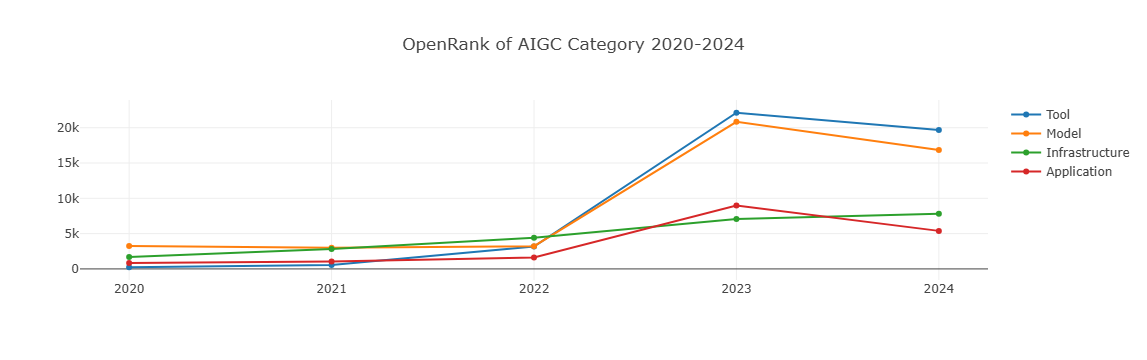

In [86]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/ai/generative_ai'],
    "startYear": startYear, "endYear": year, "endMonth": 12,
    "groupBy": 'Tech-2',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
})
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/ai/generative_ai'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_records = data_df_formated.apply(row_openrank_postprocess, axis=1).values.tolist()
title_meta = {"title": f"OpenRank of AIGC Category {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

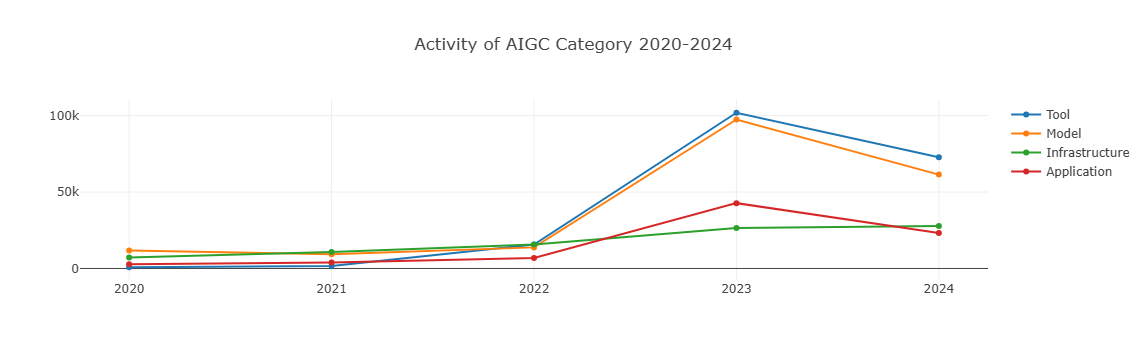

In [12]:
data = openDigger.index.activity.getRepoActivity({
    "labelUnion": [':technology/ai/generative_ai'],
    "startYear": startYear, "endYear": year, "endMonth": 12,
    "groupBy": 'Tech-2',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
})

data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/ai/generative_ai'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_records = data_df_formated.apply(row_activity_postprocess, axis=1).values.tolist()
title_meta = {"title": f"Activity of AIGC Category {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

#### 6.4.2 生成式 AI 领域项目 OpenRank 和活跃度 Top 10 变化趋势

### 生成式AI领域 OpenRank Top 10 项目近5年增长趋势

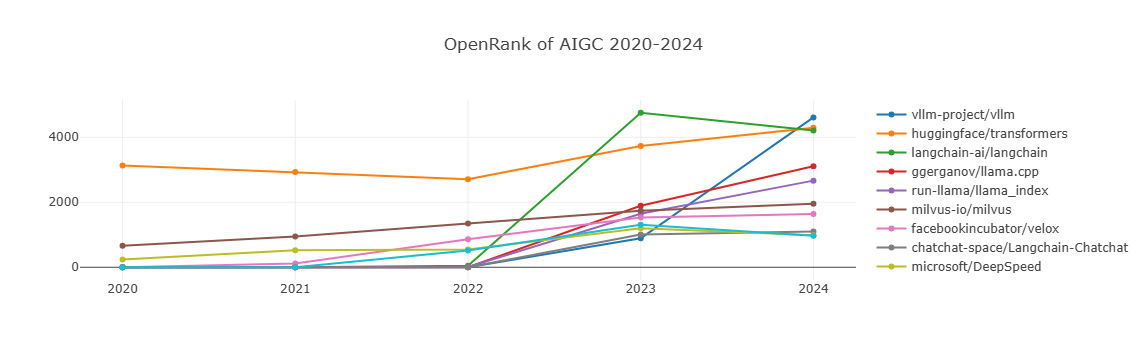

In [12]:
data = openDigger.index.openrank.getRepoOpenrank({
    "startYear": startYear, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "order": 'DESC', "labelIntersect": [':technology/ai/generative_ai'], "limit": 10
})

data_df = pd.DataFrame(data)
data_records = data_df.apply(row_openrank_postprocess, axis=1).values.tolist()
title_meta = {"title": f"OpenRank of AIGC {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

### 生成式AI领域 活跃度 Top 10 项目近5年增长趋势

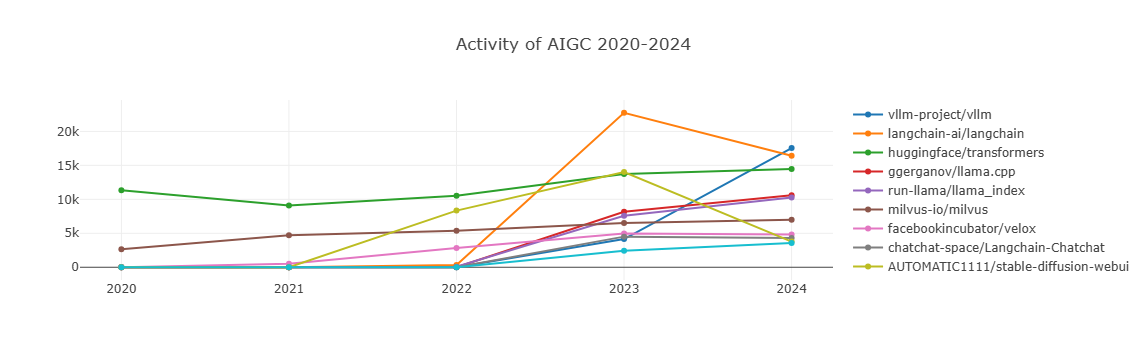

In [13]:
data = openDigger.index.activity.getRepoActivity({
    "startYear": startYear, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "order": 'DESC', "labelIntersect": [':technology/ai/generative_ai'], "limit": 10
})
data_df = pd.DataFrame(data)
data_records = data_df.apply(row_activity_postprocess, axis=1).values.tolist()
title_meta = {"title": f"Activity of AIGC {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

#### 6.4.3 2024 年生成式 AI 领域项目 OpenRank 和活跃度 Top 10 榜单

### 生成式AI领域项目 OpenRank Top 10

In [14]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/ai/generative_ai'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
data = simplify_rank_df(data, 'openrank')
displaymime(data)

|    |        id | platform   | name                              |   openrank |
|---:|----------:|:-----------|:----------------------------------|-----------:|
|  0 | 599547518 | GitHub     | vllm-project/vllm                 |    4611    |
|  1 | 155220641 | GitHub     | huggingface/transformers          |    4292.13 |
|  2 | 552661142 | GitHub     | langchain-ai/langchain            |    4212.26 |
|  3 | 612354784 | GitHub     | ggerganov/llama.cpp               |    3110.07 |
|  4 | 560704231 | GitHub     | run-llama/llama_index             |    2665.89 |
|  5 | 208728772 | GitHub     | milvus-io/milvus                  |    1955.52 |
|  6 | 388946490 | GitHub     | facebookincubator/velox           |    1641.14 |
|  7 | 621799276 | GitHub     | chatchat-space/Langchain-Chatchat |    1097.79 |
|  8 | 235860204 | GitHub     | microsoft/DeepSpeed               |     983.42 |
|  9 | 525592995 | GitHub     | invoke-ai/InvokeAI                |     971.2  |

### 生成式AI领域项目 活跃度 Top 10

In [15]:
data = openDigger.index.activity.getRepoActivity({
    "labelUnion": [':technology/ai/generative_ai'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
data = simplify_rank_df(data, 'activity')
displaymime(data)

|    |        id | platform   | name                                 |   activity |
|---:|----------:|:-----------|:-------------------------------------|-----------:|
|  0 | 599547518 | GitHub     | vllm-project/vllm                    |   17556    |
|  1 | 552661142 | GitHub     | langchain-ai/langchain               |   16413.4  |
|  2 | 155220641 | GitHub     | huggingface/transformers             |   14454.7  |
|  3 | 612354784 | GitHub     | ggerganov/llama.cpp                  |   10599.6  |
|  4 | 560704231 | GitHub     | run-llama/llama_index                |   10272.5  |
|  5 | 208728772 | GitHub     | milvus-io/milvus                     |    6978.76 |
|  6 | 388946490 | GitHub     | facebookincubator/velox              |    4832.71 |
|  7 | 621799276 | GitHub     | chatchat-space/Langchain-Chatchat    |    4315.73 |
|  8 | 527591471 | GitHub     | AUTOMATIC1111/stable-diffusion-webui |    3782.55 |
|  9 | 612781022 | GitHub     | getcursor/cursor                     |    35

In [16]:
vmc.close()